In [4]:
from ultralytics import YOLO
import os

import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import tqdm

In [5]:
class_names = ['aeroplane' ,'bicycle' ,'bird' ,'boat' ,'bottle' ,
               'bus' ,'car' ,'cat' ,'chair' ,'cow' ,'diningtable' ,
               'dog' ,'horse' ,'motorbike' ,'person' ,'pottedplant' ,
               'sheep' ,'sofa' ,'train' ,'tvmonitor']

colors = [
    [255, 0, 0],        # Красный
    [0, 255, 0],        # Зеленый
    [0, 0, 255],        # Синий
    [255, 255, 0],      # Желтый
    [255, 0, 255],      # Фиолетовый
    [0, 255, 255],      # Бирюзовый
    [128, 0, 0],        # Темно-красный
    [0, 128, 0],        # Темно-зеленый
    [0, 0, 128],        # Темно-синий
    [128, 128, 0],      # Темно-желтый
    [128, 0, 128],      # Темно-фиолетовый
    [0, 128, 128],      # Темно-бирюзовый
    [67, 67, 67],    # Серый
    [255, 165, 0],      # Оранжевый
    [67, 0, 130],    # Розовый
    [139, 69, 19],      # Коричневый
    [169, 169, 169],    # Темно-серый
    [12, 138, 14],    # Светло-зеленый
    [255, 20, 147],     # Гелиотроп
    [255, 99, 71]       # Темно-красный
] #, dtype=np.uint8


In [6]:
def draw_boxes(result):
    img = result.orig_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = result.boxes
    classes = boxes.cls.to('cpu').numpy().astype(int)
    conf = boxes.conf.to('cpu').numpy()
    boxes = list(boxes.xyxy.to('cpu').numpy().astype(int))

    labels = []
    for box,class_index,conf  in zip(boxes, classes, conf):
        labels.append(result.names[class_index])
        img = cv2.rectangle(img=img, pt1=box[:2], pt2=box[2:], color=colors[class_index], thickness=2)
        img = cv2.putText(img, result.names[class_index], (box[0],box[1] - 2), 
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=colors[class_index],thickness=1)
    return img, labels
    # plt.figure(figsize=(6,6))
    # plt.imshow(img)

In [7]:
def get_annotations(label_file):
    with open(label_file) as f:
        annotations = f.read().splitlines()
        annotations = [ x.split(' ') for x in annotations]
        for index, _ in enumerate(annotations):
            annotations[index][1:] = [float(x) for x in annotations[index][1:]]
            annotations[index][0] = int(annotations[index][0])
    return annotations

def draw_annotations(image_file, label_file, scale = 2):
    annotations = get_annotations(label_file)

    labels = []

    image = cv2.imread(image_file, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Размеры оригинального изображения
    height, width, _ = image.shape
    image = cv2.resize(image, (width*scale, height*scale), 
               interpolation = cv2.INTER_LINEAR)
    
    # Размеры ресайзнутого изображения
    height, width, _ = image.shape
    
    

    # Отобразить аннотации на изображении
    for annotation in annotations:
        class_index, x_center, y_center, w, h = annotation
        class_index = int(class_index)
        labels.append(class_names[class_index])
        
        # Преобразование относительных координат в абсолютные
        x = int(x_center * width)
        y = int(y_center * height)
        w = int(w * width)
        h = int(h * height)

        # Вычислить координаты углов прямоугольника
        x_min = int(x - w / 2)
        y_min = int(y - h / 2)
        x_max = int(x + w / 2)
        y_max = int(y + h / 2)

        # Отобразить прямоугольник на изображении
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=colors[class_index], thickness=3)




        fontScale = 1
        # # Отобразить прямоугольник на изображении для текста
        # image = cv2.rectangle(image, (x_min, y_min - 2), 
        #                       ((x_min + fontScale), ((y_min - 2) + fontScale*len(class_names[class_index]))), 
        #                       color=colors[class_index], thickness=2)

        image = cv2.rectangle(image, (x_min, y_min - 2), ((x_min + int(fontScale*20*len(class_names[class_index]))), y_min - int(fontScale*27)), 
                        color=colors[class_index], thickness=-1)
        # Добавить метку класса
        image = cv2.putText(image, class_names[class_index], (x_min, y_min - 2), 
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=fontScale, color=[255,255,255],thickness=2)
        
    return image, labels


In [8]:
dataset_dir = '../datasets/VOC'
split = 'test'
files = sorted([x.split('.')[0] for x in os.listdir(f'{dataset_dir}/images/{split}')])
save_dir = '../data/outputs/gd_vs_orig'


os.makedirs(save_dir, exist_ok=True)

###########################
for index in tqdm.tqdm(files):
    image_file = f'{dataset_dir}/images/{split}/{index}.jpg'
    label_file_orig = f'{dataset_dir}/labels/{split}_orig/{index}.txt'
    label_file_GD = f'{dataset_dir}/labels/{split}_GD/{index}.txt'


    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
    ann = draw_annotations(image_file, label_file_orig)
    pred = draw_annotations(image_file, label_file_GD)
    # print('predictions - ', pred[1])
    # print('annotations - ', ann[1])

    axs[0].axis('off')


    axs[0].imshow(pred[0])
    axs[0].set_title('Grounding DINO pseudo labels',fontsize=20)


    axs[1].axis('off')
    axs[1].set_title('Annotations',fontsize=20)
    axs[1].imshow(ann[0])

    fig.savefig(f'{save_dir}/{index}.png')

  0%|          | 0/4952 [00:00<?, ?it/s]

predictions -  ['person', 'dog']
annotations -  ['dog', 'person']


  0%|          | 1/4952 [00:00<39:03,  2.11it/s]

predictions -  ['train']
annotations -  ['train']


  0%|          | 2/4952 [00:00<39:54,  2.07it/s]

predictions -  ['sofa', 'sofa']
annotations -  ['sofa', 'chair']


  0%|          | 3/4952 [00:01<35:33,  2.32it/s]

predictions -  ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
annotations -  ['car', 'car', 'car', 'car', 'car', 'car', 'car']


  0%|          | 4/4952 [00:01<36:33,  2.26it/s]

predictions -  ['diningtable', 'pottedplant', 'chair']
annotations -  ['pottedplant', 'diningtable', 'chair', 'chair']


  0%|          | 5/4952 [00:02<33:05,  2.49it/s]

predictions -  ['chair', 'sofa']
annotations -  ['chair']


  0%|          | 6/4952 [00:02<30:41,  2.69it/s]

predictions -  ['horse', 'person']
annotations -  ['horse', 'person']


  0%|          | 7/4952 [00:02<33:35,  2.45it/s]

predictions -  ['cat', 'diningtable']
annotations -  ['cat']


  0%|          | 8/4952 [00:03<30:54,  2.67it/s]

predictions -  ['cow']
annotations -  ['cow']


  0%|          | 9/4952 [00:03<29:54,  2.75it/s]

predictions -  ['tvmonitor', 'sofa', 'person', 'person', 'person', 'motorbike']
annotations -  ['bus', 'car', 'car', 'person', 'person', 'person']


  0%|          | 10/4952 [00:03<28:47,  2.86it/s]

predictions -  ['bicycle', 'person']
annotations -  ['bicycle']


  0%|          | 11/4952 [00:04<27:53,  2.95it/s]

predictions -  ['dog']
annotations -  ['dog']


  0%|          | 12/4952 [00:04<27:04,  3.04it/s]

predictions -  ['horse', 'person']
annotations -  ['horse', 'person']


  0%|          | 13/4952 [00:04<26:32,  3.10it/s]

predictions -  ['person', 'person', 'person']
annotations -  ['cow', 'cow', 'cow', 'person', 'person', 'person', 'cow', 'person', 'person', 'person']


  0%|          | 14/4952 [00:05<26:27,  3.11it/s]

predictions -  ['person']
annotations -  ['person']


  0%|          | 15/4952 [00:05<28:29,  2.89it/s]

predictions -  ['diningtable']
annotations -  ['cat']


  0%|          | 16/4952 [00:05<30:28,  2.70it/s]

predictions -  ['dog']
annotations -  ['dog']


  0%|          | 17/4952 [00:06<28:44,  2.86it/s]

predictions -  ['train']
annotations -  ['train']


  0%|          | 18/4952 [00:06<27:52,  2.95it/s]

predictions -  ['dog']
annotations -  ['dog']


  0%|          | 19/4952 [00:06<27:47,  2.96it/s]

predictions -  ['person', 'bicycle']
annotations -  ['bicycle', 'motorbike', 'person']


  0%|          | 20/4952 [00:07<31:22,  2.62it/s]/tmp/ipykernel_10996/1938569809.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))


predictions -  ['bird']
annotations -  ['bird']


  0%|          | 21/4952 [00:07<29:18,  2.80it/s]

predictions -  ['person', 'person', 'sofa']
annotations -  ['person', 'person', 'person']


  0%|          | 22/4952 [00:08<32:47,  2.51it/s]

predictions -  ['bottle', 'tvmonitor']
annotations -  ['tvmonitor']


  0%|          | 23/4952 [00:08<29:29,  2.79it/s]

predictions -  ['cat']
annotations -  ['cat']


  0%|          | 24/4952 [00:08<28:23,  2.89it/s]

predictions -  ['cat', 'chair']
annotations -  ['cat']


  1%|          | 25/4952 [00:09<27:42,  2.96it/s]

predictions -  ['bus']
annotations -  ['bus']


  1%|          | 26/4952 [00:09<27:14,  3.01it/s]

predictions -  ['bicycle', 'person', 'person']
annotations -  ['motorbike', 'person', 'person']


  1%|          | 27/4952 [00:09<27:05,  3.03it/s]

predictions -  ['horse']
annotations -  ['horse']


  1%|          | 28/4952 [00:10<26:24,  3.11it/s]

predictions -  ['bird']
annotations -  ['bird']


  1%|          | 29/4952 [00:10<26:19,  3.12it/s]

predictions -  ['car', 'person', 'person', 'motorbike', 'person']
annotations -  ['person', 'person', 'person', 'motorbike']


  1%|          | 30/4952 [00:10<27:07,  3.02it/s]

predictions -  ['tvmonitor', 'person', 'chair']
annotations -  ['tvmonitor', 'tvmonitor', 'person', 'person', 'person']


  1%|          | 31/4952 [00:11<29:14,  2.80it/s]

predictions -  ['sheep']
annotations -  ['sheep']


  1%|          | 32/4952 [00:11<28:36,  2.87it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  1%|          | 33/4952 [00:11<26:34,  3.09it/s]

predictions -  ['bird']
annotations -  ['bird']


  1%|          | 34/4952 [00:12<27:03,  3.03it/s]

predictions -  ['person', 'boat']
annotations -  ['boat', 'person']


  1%|          | 35/4952 [00:12<26:43,  3.07it/s]

predictions -  ['sofa', 'pottedplant', 'pottedplant']
annotations -  ['pottedplant']


  1%|          | 36/4952 [00:12<26:50,  3.05it/s]

predictions -  ['car']
annotations -  ['car']


  1%|          | 37/4952 [00:13<26:41,  3.07it/s]

predictions -  ['car']
annotations -  ['car']


  1%|          | 38/4952 [00:13<26:34,  3.08it/s]

predictions -  ['dog']
annotations -  ['dog']


  1%|          | 39/4952 [00:13<30:40,  2.67it/s]

predictions -  ['person', 'person', 'person', 'person', 'person', 'person', 'person', 'bottle', 'person']
annotations -  ['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


  1%|          | 40/4952 [00:14<33:51,  2.42it/s]

predictions -  ['horse', 'sofa', 'cat']
annotations -  ['dog']


  1%|          | 41/4952 [00:14<31:16,  2.62it/s]

predictions -  ['diningtable', 'boat', 'boat', 'boat', 'boat']
annotations -  ['boat', 'boat']


  1%|          | 42/4952 [00:14<29:31,  2.77it/s]

predictions -  ['car', 'car']
annotations -  ['car', 'car']


  1%|          | 43/4952 [00:15<27:31,  2.97it/s]

predictions -  ['sofa', 'diningtable']
annotations -  ['chair', 'chair', 'chair', 'chair', 'diningtable']


  1%|          | 44/4952 [00:15<27:21,  2.99it/s]

predictions -  ['person', 'diningtable', 'person']
annotations -  ['person', 'person']


  1%|          | 45/4952 [00:15<26:46,  3.05it/s]

predictions -  ['dog', 'horse', 'diningtable']
annotations -  ['dog']


  1%|          | 46/4952 [00:16<26:24,  3.10it/s]

predictions -  ['train']
annotations -  ['train']


  1%|          | 47/4952 [00:16<29:07,  2.81it/s]

predictions -  ['train']
annotations -  ['train']


  1%|          | 48/4952 [00:16<28:06,  2.91it/s]

predictions -  ['person', 'chair', 'person']
annotations -  ['chair', 'person']


  1%|          | 49/4952 [00:17<27:08,  3.01it/s]

predictions -  ['cat', 'bus']
annotations -  ['cat']


  1%|          | 50/4952 [00:17<27:04,  3.02it/s]

predictions -  ['motorbike']
annotations -  ['motorbike']


  1%|          | 51/4952 [00:17<27:31,  2.97it/s]

predictions -  ['person', 'person', 'bus']
annotations -  ['person', 'person']


  1%|          | 52/4952 [00:18<29:49,  2.74it/s]

predictions -  ['person', 'chair', 'sofa', 'diningtable']
annotations -  ['sofa', 'chair', 'person']


  1%|          | 53/4952 [00:18<30:17,  2.69it/s]

predictions -  ['cat']
annotations -  ['cat']


  1%|          | 54/4952 [00:19<28:35,  2.85it/s]

predictions -  ['train']
annotations -  ['train']


  1%|          | 55/4952 [00:19<26:25,  3.09it/s]

predictions -  ['car', 'car', 'car']
annotations -  ['car', 'car', 'car']


  1%|          | 56/4952 [00:19<26:22,  3.09it/s]

predictions -  ['boat', 'person', 'person']
annotations -  ['boat', 'person', 'person']


  1%|          | 57/4952 [00:19<26:26,  3.09it/s]

predictions -  ['bird']
annotations -  ['bird']


  1%|          | 58/4952 [00:20<25:40,  3.18it/s]

predictions -  ['sofa', 'dog']
annotations -  ['dog', 'dog', 'sofa']


  1%|          | 59/4952 [00:20<26:03,  3.13it/s]

predictions -  ['person', 'person', 'person', 'person', 'person', 'bicycle', 'bicycle', 'motorbike']
annotations -  ['person', 'person', 'person', 'motorbike']


  1%|          | 60/4952 [00:20<25:40,  3.18it/s]

predictions -  ['cat', 'person', 'chair']
annotations -  ['cat']


  1%|          | 61/4952 [00:21<25:48,  3.16it/s]

predictions -  ['bird']
annotations -  ['bird']


  1%|▏         | 62/4952 [00:21<29:43,  2.74it/s]

predictions -  ['sofa', 'pottedplant', 'diningtable', 'pottedplant', 'chair', 'bottle']
annotations -  ['chair', 'pottedplant', 'pottedplant']


  1%|▏         | 63/4952 [00:22<30:03,  2.71it/s]

predictions -  ['cat', 'diningtable']
annotations -  ['cat']


  1%|▏         | 64/4952 [00:22<29:06,  2.80it/s]

predictions -  ['person', 'person', 'pottedplant', 'person', 'bottle']
annotations -  ['person', 'person', 'person', 'pottedplant']


  1%|▏         | 65/4952 [00:22<33:30,  2.43it/s]

predictions -  ['diningtable', 'person', 'person', 'person']
annotations -  ['diningtable']


  1%|▏         | 66/4952 [00:23<29:05,  2.80it/s]

predictions -  ['person', 'bird', 'bird', 'bird']
annotations -  ['bird', 'bird', 'person']


  1%|▏         | 67/4952 [00:23<28:59,  2.81it/s]

predictions -  ['aeroplane', 'person', 'person', 'person', 'person']
annotations -  ['aeroplane']


  1%|▏         | 68/4952 [00:23<28:07,  2.89it/s]

predictions -  ['car']
annotations -  ['car']


  1%|▏         | 69/4952 [00:24<27:32,  2.96it/s]

predictions -  ['cat', 'bottle', 'pottedplant']
annotations -  ['cat']


  1%|▏         | 70/4952 [00:24<26:40,  3.05it/s]

predictions -  ['car', 'person']
annotations -  ['car']


  1%|▏         | 71/4952 [00:24<28:48,  2.82it/s]

predictions -  ['bicycle', 'person', 'person']
annotations -  ['bicycle', 'person', 'person']


  1%|▏         | 72/4952 [00:25<27:12,  2.99it/s]

predictions -  ['diningtable', 'person', 'person', 'chair', 'person', 'person', 'bottle', 'bottle']
annotations -  ['diningtable', 'bottle', 'bottle', 'person', 'person', 'person', 'person']


  1%|▏         | 73/4952 [00:25<26:54,  3.02it/s]

predictions -  ['train']
annotations -  ['train']


  1%|▏         | 74/4952 [00:25<25:16,  3.22it/s]

predictions -  ['bird']
annotations -  ['bird']


  2%|▏         | 75/4952 [00:26<25:07,  3.24it/s]

predictions -  ['pottedplant', 'diningtable']
annotations -  ['pottedplant']


  2%|▏         | 76/4952 [00:26<26:08,  3.11it/s]

predictions -  ['person', 'bottle']
annotations -  ['bottle', 'person']


  2%|▏         | 77/4952 [00:26<29:01,  2.80it/s]

predictions -  ['car', 'car', 'car', 'car']
annotations -  ['car', 'car', 'car', 'car']


  2%|▏         | 78/4952 [00:27<27:54,  2.91it/s]

predictions -  ['person', 'person', 'person']
annotations -  ['bicycle', 'bicycle', 'person', 'person', 'person']


  2%|▏         | 79/4952 [00:27<27:59,  2.90it/s]

predictions -  ['sofa', 'cat']
annotations -  ['cat', 'chair']


  2%|▏         | 80/4952 [00:27<25:53,  3.14it/s]

predictions -  ['sofa', 'tvmonitor']
annotations -  ['sofa']


  2%|▏         | 81/4952 [00:28<25:45,  3.15it/s]

predictions -  ['horse', 'person', 'person', 'person', 'person', 'person']
annotations -  ['person', 'person', 'person', 'person', 'person', 'horse']


  2%|▏         | 82/4952 [00:28<25:28,  3.19it/s]

predictions -  ['horse']
annotations -  ['dog']


  2%|▏         | 83/4952 [00:28<24:39,  3.29it/s]

predictions -  ['horse', 'person', 'car']
annotations -  ['person', 'horse']


  2%|▏         | 84/4952 [00:29<26:27,  3.07it/s]

predictions -  ['car']
annotations -  ['car']


  2%|▏         | 85/4952 [00:29<25:51,  3.14it/s]

predictions -  ['sheep', 'sheep']
annotations -  ['sheep']


  2%|▏         | 86/4952 [00:29<25:10,  3.22it/s]

predictions -  ['sheep', 'sheep', 'sheep']
annotations -  ['sheep', 'sheep', 'sheep', 'sheep']


  2%|▏         | 87/4952 [00:30<28:14,  2.87it/s]

predictions -  ['bottle', 'bottle', 'bottle', 'bottle', 'person', 'diningtable', 'bottle', 'person', 'bottle']
annotations -  ['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'person']


  2%|▏         | 88/4952 [00:30<28:18,  2.86it/s]

predictions -  ['boat', 'boat', 'boat']
annotations -  ['boat', 'boat', 'boat', 'boat']


  2%|▏         | 89/4952 [00:30<28:42,  2.82it/s]

predictions -  ['diningtable', 'person', 'person']
annotations -  ['person', 'person', 'person']


  2%|▏         | 90/4952 [00:31<28:03,  2.89it/s]

predictions -  ['person', 'sofa']
annotations -  ['person']


  2%|▏         | 91/4952 [00:31<27:52,  2.91it/s]

predictions -  ['diningtable', 'person', 'dog', 'bottle']
annotations -  ['dog']


  2%|▏         | 92/4952 [00:31<27:53,  2.90it/s]

predictions -  ['person', 'tvmonitor', 'diningtable', 'chair', 'sofa']
annotations -  ['person', 'chair', 'tvmonitor']


  2%|▏         | 93/4952 [00:32<29:01,  2.79it/s]

predictions -  ['bird']
annotations -  ['bird']


  2%|▏         | 94/4952 [00:32<27:08,  2.98it/s]

predictions -  ['bus', 'person', 'car', 'car']
annotations -  ['bus', 'person', 'car', 'car']


  2%|▏         | 95/4952 [00:32<24:23,  3.32it/s]

predictions -  ['person', 'person', 'person', 'person', 'person', 'person']
annotations -  ['person', 'person', 'person', 'person', 'person', 'person']


  2%|▏         | 96/4952 [00:33<26:15,  3.08it/s]

predictions -  ['bus']
annotations -  ['bus']


  2%|▏         | 97/4952 [00:33<32:20,  2.50it/s]

predictions -  ['sofa', 'pottedplant', 'chair']
annotations -  ['chair', 'chair', 'chair', 'chair']


  2%|▏         | 98/4952 [00:33<30:21,  2.66it/s]

predictions -  ['car']
annotations -  ['car']


  2%|▏         | 99/4952 [00:34<29:19,  2.76it/s]

predictions -  ['bird']
annotations -  ['bird']


  2%|▏         | 100/4952 [00:34<27:44,  2.91it/s]

predictions -  ['motorbike', 'person', 'person']
annotations -  ['person', 'person', 'person', 'motorbike', 'motorbike']


  2%|▏         | 101/4952 [00:34<26:48,  3.02it/s]

predictions -  ['bottle', 'person', 'person']
annotations -  ['bottle', 'person']


  2%|▏         | 102/4952 [00:35<27:18,  2.96it/s]

predictions -  ['tvmonitor']
annotations -  ['tvmonitor']


  2%|▏         | 103/4952 [00:35<26:43,  3.02it/s]

predictions -  ['sofa', 'person', 'dog', 'pottedplant']
annotations -  ['person', 'dog', 'sofa']


  2%|▏         | 104/4952 [00:35<28:34,  2.83it/s]

predictions -  ['person', 'person']
annotations -  ['person']


  2%|▏         | 105/4952 [00:36<30:50,  2.62it/s]

predictions -  ['diningtable', 'person', 'person', 'person']
annotations -  ['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


  2%|▏         | 106/4952 [00:36<29:20,  2.75it/s]

predictions -  ['cat', 'tvmonitor', 'bottle']
annotations -  ['cat']


  2%|▏         | 107/4952 [00:37<32:53,  2.45it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  2%|▏         | 108/4952 [00:37<28:52,  2.80it/s]

predictions -  ['diningtable', 'bottle']
annotations -  ['diningtable', 'chair', 'chair', 'chair', 'chair', 'chair']


  2%|▏         | 109/4952 [00:37<27:32,  2.93it/s]

predictions -  ['train', 'pottedplant']
annotations -  ['train']


  2%|▏         | 110/4952 [00:38<26:17,  3.07it/s]

predictions -  ['person', 'diningtable', 'bottle', 'chair']
annotations -  ['chair', 'chair', 'chair', 'diningtable', 'person', 'person']


  2%|▏         | 111/4952 [00:38<26:05,  3.09it/s]

predictions -  ['cat', 'tvmonitor', 'chair']
annotations -  ['cat', 'tvmonitor']


  2%|▏         | 112/4952 [00:38<26:02,  3.10it/s]

predictions -  ['bicycle', 'person']
annotations -  ['bicycle', 'person']


  2%|▏         | 113/4952 [00:39<26:05,  3.09it/s]

predictions -  ['bus', 'person']
annotations -  ['bus', 'person']


  2%|▏         | 114/4952 [00:39<25:39,  3.14it/s]

predictions -  ['chair']
annotations -  ['chair', 'pottedplant', 'pottedplant', 'pottedplant']


  2%|▏         | 115/4952 [00:39<25:32,  3.16it/s]

predictions -  ['horse', 'person']
annotations -  ['person', 'horse']


  2%|▏         | 116/4952 [00:40<25:46,  3.13it/s]

predictions -  ['train', 'person']
annotations -  ['train', 'person']


  2%|▏         | 117/4952 [00:40<26:17,  3.07it/s]

predictions -  ['bus', 'person', 'person', 'chair']
annotations -  ['bus', 'person', 'person']


  2%|▏         | 118/4952 [00:40<25:37,  3.14it/s]

predictions -  ['person', 'car', 'person', 'car', 'car', 'car', 'car']
annotations -  ['boat', 'car', 'car', 'car', 'person', 'person', 'car']


  2%|▏         | 119/4952 [00:40<26:20,  3.06it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  2%|▏         | 120/4952 [00:41<24:24,  3.30it/s]

predictions -  ['chair', 'person', 'person']
annotations -  ['chair', 'person', 'person']


  2%|▏         | 121/4952 [00:41<28:05,  2.87it/s]

predictions -  ['person', 'horse']
annotations -  ['person', 'horse']


  2%|▏         | 122/4952 [00:41<26:32,  3.03it/s]

predictions -  ['bus', 'car', 'person']
annotations -  ['car', 'bus', 'person']


  2%|▏         | 123/4952 [00:42<25:40,  3.13it/s]

predictions -  ['train']
annotations -  ['train']


  3%|▎         | 124/4952 [00:42<25:17,  3.18it/s]

predictions -  ['car', 'car', 'car']
annotations -  ['car', 'car', 'car']


  3%|▎         | 125/4952 [00:42<24:02,  3.35it/s]

predictions -  ['dog']
annotations -  ['dog']


  3%|▎         | 126/4952 [00:43<23:40,  3.40it/s]

predictions -  ['person', 'sheep']
annotations -  ['dog', 'person']


  3%|▎         | 127/4952 [00:43<23:42,  3.39it/s]

predictions -  ['aeroplane', 'person', 'aeroplane', 'person']
annotations -  ['aeroplane', 'aeroplane']


  3%|▎         | 128/4952 [00:43<23:40,  3.40it/s]

predictions -  ['motorbike']
annotations -  ['bicycle', 'bicycle']


  3%|▎         | 129/4952 [00:44<24:46,  3.24it/s]

predictions -  ['person', 'motorbike']
annotations -  ['motorbike', 'person']


  3%|▎         | 130/4952 [00:44<25:43,  3.12it/s]

predictions -  ['tvmonitor', 'person', 'person', 'motorbike', 'person', 'pottedplant']
annotations -  ['tvmonitor', 'person', 'person', 'person', 'person', 'person']


  3%|▎         | 131/4952 [00:44<24:44,  3.25it/s]

predictions -  ['horse', 'cat']
annotations -  ['horse']


  3%|▎         | 132/4952 [00:45<27:15,  2.95it/s]

predictions -  ['car', 'person', 'person', 'person']
annotations -  ['car', 'person', 'person']


  3%|▎         | 133/4952 [00:45<26:40,  3.01it/s]

predictions -  ['person', 'bottle']
annotations -  ['person']


  3%|▎         | 134/4952 [00:45<28:30,  2.82it/s]

predictions -  ['horse']
annotations -  ['cow']


  3%|▎         | 135/4952 [00:46<28:07,  2.85it/s]

predictions -  ['bird']
annotations -  ['bird']


  3%|▎         | 136/4952 [00:46<36:04,  2.23it/s]

predictions -  ['sofa', 'bottle']
annotations -  ['sofa']


  3%|▎         | 137/4952 [00:47<33:27,  2.40it/s]

predictions -  ['person', 'person', 'sofa', 'person']
annotations -  ['person', 'person', 'person']


  3%|▎         | 138/4952 [00:47<30:27,  2.63it/s]

predictions -  ['person', 'diningtable', 'chair', 'tvmonitor', 'bottle']
annotations -  ['bottle', 'bottle', 'bottle', 'person', 'diningtable']


  3%|▎         | 139/4952 [00:47<29:42,  2.70it/s]

predictions -  ['train']
annotations -  ['train']


  3%|▎         | 140/4952 [00:48<27:14,  2.94it/s]

predictions -  ['person', 'person', 'bicycle', 'bicycle']
annotations -  ['person', 'person', 'bicycle', 'bicycle']


  3%|▎         | 141/4952 [00:48<27:44,  2.89it/s]

predictions -  ['car', 'car']
annotations -  ['car']


  3%|▎         | 142/4952 [00:48<26:49,  2.99it/s]

predictions -  ['person', 'chair', 'person']
annotations -  ['person', 'person']


  3%|▎         | 143/4952 [00:49<27:05,  2.96it/s]

predictions -  ['person', 'person']
annotations -  ['person', 'person']


  3%|▎         | 144/4952 [00:49<27:05,  2.96it/s]

predictions -  ['dog']
annotations -  ['dog']


  3%|▎         | 145/4952 [00:49<27:54,  2.87it/s]

predictions -  ['bottle', 'bottle', 'tvmonitor', 'tvmonitor', 'person', 'bottle']
annotations -  ['tvmonitor', 'tvmonitor', 'person', 'person']


  3%|▎         | 146/4952 [00:50<27:35,  2.90it/s]

predictions -  ['diningtable', 'cat']
annotations -  ['cat']


  3%|▎         | 147/4952 [00:50<27:08,  2.95it/s]

predictions -  ['person', 'person', 'train', 'person', 'car']
annotations -  ['person', 'person', 'person', 'person', 'car', 'car']


  3%|▎         | 148/4952 [00:50<26:38,  3.01it/s]

predictions -  ['boat', 'boat', 'pottedplant']
annotations -  ['boat']


  3%|▎         | 149/4952 [00:51<25:47,  3.10it/s]

predictions -  ['cow', 'person']
annotations -  ['cow', 'person', 'person']


  3%|▎         | 150/4952 [00:51<26:57,  2.97it/s]

predictions -  ['person', 'sofa', 'bottle']
annotations -  ['person', 'person', 'person']


  3%|▎         | 151/4952 [00:51<27:04,  2.96it/s]

predictions -  ['car']
annotations -  ['car']


  3%|▎         | 152/4952 [00:52<28:26,  2.81it/s]

predictions -  ['car', 'car']
annotations -  ['car', 'car']


  3%|▎         | 153/4952 [00:52<29:18,  2.73it/s]

predictions -  ['bird']
annotations -  ['bird']


  3%|▎         | 154/4952 [00:52<28:48,  2.78it/s]

predictions -  ['person', 'person', 'person']
annotations -  ['person', 'person', 'person', 'person']


  3%|▎         | 155/4952 [00:53<27:51,  2.87it/s]

predictions -  ['car', 'car', 'car', 'car', 'car', 'car', 'car']
annotations -  ['car', 'car', 'car', 'car', 'car', 'car', 'car']


  3%|▎         | 156/4952 [00:53<26:53,  2.97it/s]

predictions -  ['sofa', 'bottle', 'diningtable']
annotations -  ['sofa', 'chair', 'chair', 'chair', 'diningtable']


  3%|▎         | 157/4952 [00:53<26:15,  3.04it/s]

predictions -  ['person', 'person', 'person']
annotations -  ['person', 'person', 'person']


  3%|▎         | 158/4952 [00:54<28:44,  2.78it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  3%|▎         | 159/4952 [00:54<25:38,  3.12it/s]

predictions -  ['horse', 'person', 'horse']
annotations -  ['horse', 'horse', 'person']


  3%|▎         | 160/4952 [00:54<25:13,  3.17it/s]

predictions -  ['dog']
annotations -  ['dog']


  3%|▎         | 161/4952 [00:55<24:14,  3.29it/s]

predictions -  ['bird']
annotations -  ['bird']


  3%|▎         | 162/4952 [00:55<24:57,  3.20it/s]

predictions -  ['diningtable', 'bottle', 'chair', 'cat']
annotations -  ['bottle', 'diningtable']


  3%|▎         | 163/4952 [00:55<25:35,  3.12it/s]

predictions -  ['horse', 'person']
annotations -  ['person', 'horse']


  3%|▎         | 164/4952 [00:56<25:55,  3.08it/s]

predictions -  ['train']
annotations -  ['train']


  3%|▎         | 165/4952 [00:56<25:15,  3.16it/s]

predictions -  ['bottle']
annotations -  ['bottle']


  3%|▎         | 166/4952 [00:56<27:56,  2.85it/s]

predictions -  ['person', 'sofa', 'person', 'person', 'person']
annotations -  ['chair', 'person', 'person', 'person', 'person']


  3%|▎         | 167/4952 [00:57<27:52,  2.86it/s]

predictions -  ['bus', 'car', 'car', 'car', 'car']
annotations -  ['bus', 'person', 'car', 'car', 'car', 'car']


  3%|▎         | 168/4952 [00:57<26:18,  3.03it/s]

predictions -  ['person', 'tvmonitor', 'aeroplane']
annotations -  ['person']


  3%|▎         | 169/4952 [00:57<25:34,  3.12it/s]

predictions -  ['cow']
annotations -  ['cow']


  3%|▎         | 170/4952 [00:58<25:25,  3.13it/s]

predictions -  ['bottle', 'person', 'diningtable', 'person']
annotations -  ['bottle', 'person', 'person', 'person']


  3%|▎         | 171/4952 [00:58<25:59,  3.07it/s]

predictions -  ['motorbike', 'person', 'person', 'person', 'pottedplant']
annotations -  ['person', 'person', 'person', 'motorbike']


  3%|▎         | 172/4952 [00:58<25:16,  3.15it/s]

predictions -  ['boat']
annotations -  ['boat']


  3%|▎         | 173/4952 [00:59<24:53,  3.20it/s]

predictions -  ['car']
annotations -  ['car']


  4%|▎         | 174/4952 [00:59<23:48,  3.34it/s]

predictions -  ['motorbike']
annotations -  ['motorbike']


  4%|▎         | 175/4952 [00:59<24:13,  3.29it/s]

predictions -  ['horse', 'person']
annotations -  ['person', 'horse']


  4%|▎         | 176/4952 [01:00<28:00,  2.84it/s]

predictions -  ['bird']
annotations -  ['bird']


  4%|▎         | 177/4952 [01:00<27:16,  2.92it/s]

predictions -  ['person', 'car']
annotations -  ['car', 'person']


  4%|▎         | 178/4952 [01:00<26:57,  2.95it/s]

predictions -  ['cow']
annotations -  ['cow']


  4%|▎         | 179/4952 [01:01<26:26,  3.01it/s]

predictions -  ['car', 'car']
annotations -  ['car', 'car']


  4%|▎         | 180/4952 [01:01<26:33,  3.00it/s]

predictions -  ['dog', 'bottle']
annotations -  ['dog']


  4%|▎         | 181/4952 [01:01<25:41,  3.09it/s]

predictions -  ['person', 'motorbike']
annotations -  ['motorbike', 'motorbike', 'person']


  4%|▎         | 182/4952 [01:02<26:09,  3.04it/s]

predictions -  ['cat', 'pottedplant']
annotations -  ['cat']


  4%|▎         | 183/4952 [01:02<29:05,  2.73it/s]

predictions -  ['diningtable', 'chair', 'tvmonitor', 'chair']
annotations -  ['diningtable', 'chair', 'chair']


  4%|▎         | 184/4952 [01:03<40:41,  1.95it/s]

predictions -  ['person']
annotations -  ['person']


  4%|▎         | 185/4952 [01:03<38:36,  2.06it/s]

predictions -  ['diningtable', 'person', 'person', 'person', 'bottle']
annotations -  ['bottle', 'person', 'person', 'person']


  4%|▍         | 186/4952 [01:04<35:23,  2.24it/s]

predictions -  ['person', 'boat']
annotations -  ['boat']


  4%|▍         | 187/4952 [01:04<32:27,  2.45it/s]

predictions -  ['person', 'boat']
annotations -  ['boat']


  4%|▍         | 188/4952 [01:04<30:49,  2.58it/s]

predictions -  ['sheep']
annotations -  ['sheep']


  4%|▍         | 189/4952 [01:05<28:59,  2.74it/s]

predictions -  ['diningtable', 'person', 'person', 'person', 'person', 'person', 'chair']
annotations -  ['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'chair', 'chair', 'diningtable']


  4%|▍         | 190/4952 [01:05<28:18,  2.80it/s]

predictions -  ['person', 'horse']
annotations -  ['horse', 'person']


  4%|▍         | 191/4952 [01:05<30:04,  2.64it/s]

predictions -  ['bird', 'bird']
annotations -  ['bird', 'bird']


  4%|▍         | 192/4952 [01:06<29:03,  2.73it/s]

predictions -  ['sofa', 'diningtable']
annotations -  ['sofa']


  4%|▍         | 193/4952 [01:06<27:11,  2.92it/s]

predictions -  ['sofa', 'chair', 'bottle', 'motorbike', 'pottedplant']
annotations -  ['chair', 'chair']


  4%|▍         | 194/4952 [01:06<26:38,  2.98it/s]

predictions -  ['person', 'cow', 'cow']
annotations -  ['cow', 'cow', 'person']


  4%|▍         | 195/4952 [01:07<26:38,  2.98it/s]

predictions -  ['person', 'person']
annotations -  ['person', 'person']


  4%|▍         | 196/4952 [01:07<28:02,  2.83it/s]

predictions -  ['person', 'pottedplant', 'pottedplant', 'chair']
annotations -  ['pottedplant']


  4%|▍         | 197/4952 [01:07<28:28,  2.78it/s]

predictions -  ['car']
annotations -  ['car']


  4%|▍         | 198/4952 [01:08<28:59,  2.73it/s]

predictions -  ['horse', 'person', 'car', 'person', 'person', 'person']
annotations -  ['horse', 'person']


  4%|▍         | 199/4952 [01:08<27:11,  2.91it/s]

predictions -  ['horse', 'person']
annotations -  ['person', 'horse']


  4%|▍         | 200/4952 [01:08<26:10,  3.03it/s]

predictions -  ['tvmonitor', 'pottedplant', 'diningtable', 'pottedplant']
annotations -  ['tvmonitor', 'chair', 'pottedplant', 'pottedplant']


  4%|▍         | 201/4952 [01:09<28:45,  2.75it/s]

predictions -  ['train']
annotations -  ['train']


  4%|▍         | 202/4952 [01:09<28:32,  2.77it/s]

predictions -  ['bicycle']
annotations -  ['bicycle']


  4%|▍         | 203/4952 [01:09<27:19,  2.90it/s]

predictions -  ['diningtable', 'cat', 'bottle', 'cat']
annotations -  ['cat', 'cat']


  4%|▍         | 204/4952 [01:10<26:44,  2.96it/s]

predictions -  ['car', 'car']
annotations -  ['car']


  4%|▍         | 205/4952 [01:10<25:37,  3.09it/s]

predictions -  ['person']
annotations -  ['person']


  4%|▍         | 206/4952 [01:10<26:30,  2.98it/s]

predictions -  ['diningtable', 'person']
annotations -  ['person']


  4%|▍         | 207/4952 [01:11<29:48,  2.65it/s]

predictions -  ['person', 'person', 'horse']
annotations -  ['horse', 'person', 'person']


  4%|▍         | 208/4952 [01:11<30:15,  2.61it/s]

predictions -  ['horse']
annotations -  ['horse', 'horse']


  4%|▍         | 209/4952 [01:12<28:48,  2.74it/s]

predictions -  []
annotations -  ['person', 'person', 'person', 'horse']


  4%|▍         | 210/4952 [01:12<27:43,  2.85it/s]

predictions -  ['tvmonitor', 'person', 'pottedplant', 'diningtable']
annotations -  ['tvmonitor', 'person', 'bottle']


  4%|▍         | 211/4952 [01:12<27:37,  2.86it/s]

predictions -  ['car']
annotations -  ['car']


  4%|▍         | 212/4952 [01:13<26:51,  2.94it/s]

predictions -  ['aeroplane', 'person', 'person', 'person']
annotations -  ['aeroplane']


  4%|▍         | 213/4952 [01:13<26:05,  3.03it/s]

predictions -  ['tvmonitor', 'person']
annotations -  ['tvmonitor', 'person']


  4%|▍         | 214/4952 [01:13<26:11,  3.02it/s]

predictions -  ['dog']
annotations -  ['dog']


  4%|▍         | 215/4952 [01:14<26:43,  2.95it/s]

predictions -  ['person', 'person', 'person', 'chair']
annotations -  ['person', 'person']


  4%|▍         | 216/4952 [01:14<26:54,  2.93it/s]

predictions -  ['car']
annotations -  ['car']


  4%|▍         | 217/4952 [01:14<26:10,  3.02it/s]

predictions -  ['bird']
annotations -  ['bird']


  4%|▍         | 218/4952 [01:15<26:10,  3.02it/s]

predictions -  ['pottedplant', 'bottle', 'diningtable', 'diningtable']
annotations -  ['pottedplant', 'person']


  4%|▍         | 219/4952 [01:15<25:52,  3.05it/s]

predictions -  ['sheep', 'sheep']
annotations -  ['cow', 'cow']


  4%|▍         | 220/4952 [01:15<26:00,  3.03it/s]

predictions -  ['horse', 'person']
annotations -  ['horse', 'person']


  4%|▍         | 221/4952 [01:16<26:23,  2.99it/s]

predictions -  ['bird']
annotations -  ['bird']


  4%|▍         | 222/4952 [01:16<26:06,  3.02it/s]

predictions -  ['person', 'person', 'sheep', 'sheep']
annotations -  ['person', 'person']


  5%|▍         | 223/4952 [01:16<26:30,  2.97it/s]

predictions -  ['car']
annotations -  ['car']


  5%|▍         | 224/4952 [01:17<25:22,  3.10it/s]

predictions -  ['train']
annotations -  ['train']


  5%|▍         | 225/4952 [01:17<24:24,  3.23it/s]

predictions -  ['cat']
annotations -  ['cat']


  5%|▍         | 226/4952 [01:17<24:44,  3.18it/s]

predictions -  ['person', 'boat']
annotations -  ['boat']


  5%|▍         | 227/4952 [01:18<27:53,  2.82it/s]

predictions -  ['person', 'person', 'horse', 'person', 'person']
annotations -  ['horse', 'horse', 'horse', 'person', 'person', 'person', 'person']


  5%|▍         | 228/4952 [01:18<26:30,  2.97it/s]

predictions -  ['bottle']
annotations -  ['bottle', 'person']


  5%|▍         | 229/4952 [01:18<25:43,  3.06it/s]

predictions -  ['person', 'person', 'person', 'boat', 'person']
annotations -  ['boat', 'person', 'person', 'person']


  5%|▍         | 230/4952 [01:19<25:31,  3.08it/s]

predictions -  ['sheep']
annotations -  ['sheep']


  5%|▍         | 231/4952 [01:19<24:49,  3.17it/s]

predictions -  ['sofa', 'cat', 'diningtable']
annotations -  ['sofa']


  5%|▍         | 232/4952 [01:19<25:03,  3.14it/s]

predictions -  ['car', 'person']
annotations -  ['person', 'car']


  5%|▍         | 233/4952 [01:19<24:00,  3.28it/s]

predictions -  ['horse', 'person']
annotations -  ['person', 'horse']


  5%|▍         | 234/4952 [01:20<23:42,  3.32it/s]

predictions -  ['bus', 'person', 'bottle']
annotations -  ['bus', 'person']


  5%|▍         | 235/4952 [01:20<24:34,  3.20it/s]

predictions -  ['person', 'sofa']
annotations -  ['person']


  5%|▍         | 236/4952 [01:21<28:37,  2.75it/s]

predictions -  ['sheep', 'person', 'person']
annotations -  ['sheep', 'person', 'person']


  5%|▍         | 237/4952 [01:21<28:13,  2.78it/s]

predictions -  ['car']
annotations -  ['car']


  5%|▍         | 238/4952 [01:21<26:41,  2.94it/s]

predictions -  ['bird']
annotations -  ['bird']


  5%|▍         | 239/4952 [01:22<25:57,  3.03it/s]

predictions -  ['person', 'person', 'person', 'person', 'person']
annotations -  ['motorbike', 'motorbike', 'motorbike', 'motorbike', 'person', 'person', 'person', 'person', 'person']


  5%|▍         | 240/4952 [01:22<25:11,  3.12it/s]

predictions -  ['car']
annotations -  ['car']


  5%|▍         | 241/4952 [01:22<23:56,  3.28it/s]

predictions -  ['bird']
annotations -  ['bird']


  5%|▍         | 242/4952 [01:22<24:49,  3.16it/s]

predictions -  ['aeroplane', 'bottle']
annotations -  ['aeroplane']


  5%|▍         | 243/4952 [01:23<23:52,  3.29it/s]

predictions -  ['sheep', 'sheep', 'cow', 'cow']
annotations -  ['sheep', 'horse']


  5%|▍         | 244/4952 [01:24<37:30,  2.09it/s]

predictions -  ['dog']
annotations -  ['dog']


  5%|▍         | 245/4952 [01:24<33:31,  2.34it/s]

predictions -  ['person', 'bottle']
annotations -  ['person']


  5%|▍         | 246/4952 [01:24<33:27,  2.34it/s]

predictions -  []
annotations -  ['boat', 'boat', 'boat']


  5%|▍         | 247/4952 [01:25<29:28,  2.66it/s]

predictions -  ['person']
annotations -  ['person']


  5%|▌         | 248/4952 [01:25<27:07,  2.89it/s]

predictions -  ['diningtable', 'pottedplant', 'sofa', 'chair', 'chair']
annotations -  ['chair', 'chair', 'chair', 'chair']


  5%|▌         | 249/4952 [01:25<26:33,  2.95it/s]

predictions -  ['car']
annotations -  ['car']


  5%|▌         | 250/4952 [01:25<25:44,  3.04it/s]

predictions -  ['diningtable', 'person', 'dog', 'person', 'person']
annotations -  ['person', 'person', 'person', 'person']


  5%|▌         | 251/4952 [01:26<24:44,  3.17it/s]

predictions -  ['person', 'person', 'person', 'person', 'person', 'chair']
annotations -  ['person', 'person', 'person', 'person', 'person']


  5%|▌         | 252/4952 [01:26<24:16,  3.23it/s]

predictions -  ['bird']
annotations -  ['bird']


  5%|▌         | 253/4952 [01:26<24:05,  3.25it/s]

predictions -  ['motorbike', 'person', 'person', 'person']
annotations -  ['motorbike', 'person', 'person', 'person', 'person']


  5%|▌         | 254/4952 [01:27<25:24,  3.08it/s]

predictions -  ['person']
annotations -  ['person']


  5%|▌         | 255/4952 [01:27<25:00,  3.13it/s]

predictions -  ['cow', 'person', 'person']
annotations -  ['cow', 'person', 'person', 'person']


  5%|▌         | 256/4952 [01:27<25:50,  3.03it/s]

predictions -  ['car', 'person', 'car']
annotations -  ['car', 'car', 'car']


  5%|▌         | 257/4952 [01:28<25:35,  3.06it/s]

predictions -  ['person', 'dog', 'person']
annotations -  ['dog', 'person']


  5%|▌         | 258/4952 [01:28<28:04,  2.79it/s]

predictions -  ['car', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']
annotations -  ['car', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


  5%|▌         | 259/4952 [01:28<27:59,  2.79it/s]

predictions -  ['diningtable', 'pottedplant']
annotations -  ['chair', 'chair', 'chair', 'chair', 'diningtable']


  5%|▌         | 260/4952 [01:29<26:44,  2.92it/s]

predictions -  ['train']
annotations -  ['train']


  5%|▌         | 261/4952 [01:29<25:30,  3.06it/s]

predictions -  ['bus']
annotations -  ['bus']


  5%|▌         | 262/4952 [01:29<25:16,  3.09it/s]

predictions -  ['person', 'bottle', 'dog', 'cat']
annotations -  ['cat', 'bottle', 'dog', 'person']


  5%|▌         | 264/4952 [01:30<22:49,  3.42it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']
predictions -  ['person', 'person', 'person', 'person', 'person', 'bicycle', 'person', 'person', 'bicycle', 'person', 'person']
annotations -  ['person', 'person', 'person', 'person', 'bicycle', 'bicycle', 'bicycle', 'bicycle']


  5%|▌         | 265/4952 [01:30<23:19,  3.35it/s]

predictions -  ['motorbike', 'boat']
annotations -  ['boat']


  5%|▌         | 266/4952 [01:31<23:03,  3.39it/s]

predictions -  ['person', 'person']
annotations -  ['motorbike', 'motorbike', 'person', 'person']


  5%|▌         | 268/4952 [01:31<21:11,  3.68it/s]

predictions -  ['sofa', 'person', 'cat']
annotations -  ['dog', 'sofa']
predictions -  ['person']
annotations -  ['person']


  5%|▌         | 269/4952 [01:31<24:03,  3.24it/s]

predictions -  ['bus', 'person']
annotations -  ['bus', 'person']


  5%|▌         | 270/4952 [01:32<24:15,  3.22it/s]

predictions -  ['person', 'person', 'boat']
annotations -  ['person']


  5%|▌         | 271/4952 [01:32<23:18,  3.35it/s]

predictions -  ['dog', 'person']
annotations -  ['person']


  5%|▌         | 272/4952 [01:32<24:30,  3.18it/s]

predictions -  ['cat']
annotations -  ['cat']


  6%|▌         | 273/4952 [01:33<24:46,  3.15it/s]

predictions -  ['person', 'dog']
annotations -  ['dog', 'person']


  6%|▌         | 274/4952 [01:33<25:19,  3.08it/s]

predictions -  ['person', 'pottedplant', 'person', 'person', 'person']
annotations -  ['chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'diningtable', 'diningtable', 'person', 'person', 'chair', 'chair', 'chair', 'person', 'person', 'person', 'person', 'diningtable', 'diningtable']


  6%|▌         | 275/4952 [01:34<28:41,  2.72it/s]

predictions -  ['car']
annotations -  ['car']


  6%|▌         | 276/4952 [01:34<26:53,  2.90it/s]

predictions -  ['diningtable', 'dog']
annotations -  ['dog', 'dog', 'dog']


  6%|▌         | 277/4952 [01:34<26:34,  2.93it/s]

predictions -  ['motorbike']
annotations -  ['motorbike']


  6%|▌         | 278/4952 [01:34<26:04,  2.99it/s]

predictions -  ['train', 'person']
annotations -  ['train']


  6%|▌         | 279/4952 [01:35<25:18,  3.08it/s]

predictions -  ['bird']
annotations -  ['bird']


  6%|▌         | 280/4952 [01:35<25:04,  3.10it/s]

predictions -  ['boat', 'boat']
annotations -  ['boat', 'boat']


  6%|▌         | 281/4952 [01:35<23:22,  3.33it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  6%|▌         | 282/4952 [01:36<25:26,  3.06it/s]

predictions -  ['bird', 'bird']
annotations -  ['bird', 'bird']


  6%|▌         | 283/4952 [01:36<28:11,  2.76it/s]

predictions -  ['person', 'bicycle']
annotations -  ['bicycle', 'person']


  6%|▌         | 284/4952 [01:37<27:19,  2.85it/s]

predictions -  ['person', 'sofa']
annotations -  ['person']


  6%|▌         | 285/4952 [01:37<25:16,  3.08it/s]

predictions -  ['person', 'bicycle']
annotations -  ['bicycle', 'person']


  6%|▌         | 286/4952 [01:37<24:38,  3.16it/s]

predictions -  ['bird']
annotations -  ['bird']


  6%|▌         | 287/4952 [01:37<23:23,  3.32it/s]

predictions -  ['bird']
annotations -  ['bird']


  6%|▌         | 288/4952 [01:38<24:31,  3.17it/s]

predictions -  ['motorbike', 'person']
annotations -  ['motorbike', 'person']


  6%|▌         | 289/4952 [01:38<24:12,  3.21it/s]

predictions -  ['tvmonitor', 'chair']
annotations -  ['tvmonitor', 'tvmonitor', 'tvmonitor', 'tvmonitor', 'tvmonitor']


  6%|▌         | 290/4952 [01:38<26:06,  2.98it/s]

predictions -  ['bicycle', 'car']
annotations -  ['bicycle', 'bicycle']


  6%|▌         | 291/4952 [01:39<25:15,  3.07it/s]

predictions -  ['diningtable', 'pottedplant', 'sofa', 'bottle']
annotations -  ['chair']


  6%|▌         | 292/4952 [01:39<25:24,  3.06it/s]

predictions -  ['sheep']
annotations -  ['sheep', 'sheep']


  6%|▌         | 293/4952 [01:39<25:30,  3.04it/s]

predictions -  ['sofa', 'pottedplant', 'pottedplant']
annotations -  ['pottedplant', 'pottedplant', 'sofa']


  6%|▌         | 294/4952 [01:40<26:46,  2.90it/s]

predictions -  ['boat', 'person']
annotations -  ['boat']


  6%|▌         | 295/4952 [01:40<26:03,  2.98it/s]

predictions -  ['person', 'tvmonitor', 'person']
annotations -  ['person', 'person']


  6%|▌         | 296/4952 [01:41<29:58,  2.59it/s]

predictions -  ['car', 'bottle']
annotations -  ['car']


  6%|▌         | 297/4952 [01:41<28:55,  2.68it/s]

predictions -  ['bicycle', 'sofa']
annotations -  ['bicycle']


  6%|▌         | 298/4952 [01:41<28:23,  2.73it/s]

predictions -  ['car', 'person']
annotations -  ['car']


  6%|▌         | 299/4952 [01:42<26:31,  2.92it/s]

predictions -  ['car', 'person']
annotations -  ['car', 'person']


  6%|▌         | 300/4952 [01:42<28:44,  2.70it/s]

predictions -  ['diningtable', 'bottle', 'person', 'person', 'sofa']
annotations -  ['person', 'person', 'person', 'person', 'bottle']


  6%|▌         | 301/4952 [01:42<27:45,  2.79it/s]

predictions -  ['car', 'car', 'car']
annotations -  ['car', 'car']


  6%|▌         | 302/4952 [01:43<28:00,  2.77it/s]

predictions -  ['person', 'motorbike', 'diningtable']
annotations -  ['bicycle', 'person']


  6%|▌         | 303/4952 [01:43<26:41,  2.90it/s]

predictions -  ['bottle', 'diningtable', 'chair', 'chair']
annotations -  ['chair', 'chair', 'chair', 'diningtable']


  6%|▌         | 304/4952 [01:43<26:46,  2.89it/s]

predictions -  ['sheep', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep', 'sheep']
annotations -  ['sheep']


  6%|▌         | 305/4952 [01:44<26:59,  2.87it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  6%|▌         | 306/4952 [01:44<26:46,  2.89it/s]

predictions -  ['person', 'car']
annotations -  ['person', 'car']


  6%|▌         | 307/4952 [01:44<26:04,  2.97it/s]

predictions -  ['sofa', 'pottedplant']
annotations -  ['sofa']


  6%|▌         | 308/4952 [01:45<26:15,  2.95it/s]

predictions -  ['horse', 'person']
annotations -  ['horse', 'person']


  6%|▌         | 309/4952 [01:45<29:18,  2.64it/s]

predictions -  ['diningtable', 'bottle', 'person', 'person', 'person', 'tvmonitor', 'person']
annotations -  ['diningtable', 'person', 'person', 'person', 'person', 'bottle']


  6%|▋         | 310/4952 [01:45<28:45,  2.69it/s]

predictions -  ['car', 'person', 'car', 'person', 'person', 'bottle']
annotations -  ['car', 'person', 'person', 'person', 'person', 'person', 'car']


  6%|▋         | 311/4952 [01:46<27:16,  2.84it/s]

predictions -  ['dog', 'bottle', 'diningtable']
annotations -  ['dog', 'bottle']


  6%|▋         | 312/4952 [01:46<26:31,  2.92it/s]

predictions -  ['bicycle']
annotations -  ['bicycle']


  6%|▋         | 313/4952 [01:46<25:36,  3.02it/s]

predictions -  ['person', 'tvmonitor', 'sofa', 'person', 'dog']
annotations -  ['person', 'person']


  6%|▋         | 314/4952 [01:47<25:48,  2.99it/s]

predictions -  ['horse', 'person']
annotations -  ['person', 'horse']


  6%|▋         | 315/4952 [01:47<28:13,  2.74it/s]

predictions -  ['diningtable', 'bottle']
annotations -  ['diningtable', 'person']


  6%|▋         | 316/4952 [01:48<27:40,  2.79it/s]

predictions -  ['aeroplane', 'aeroplane']
annotations -  ['aeroplane', 'aeroplane']


  6%|▋         | 317/4952 [01:48<25:48,  2.99it/s]

predictions -  ['person', 'diningtable', 'person', 'chair']
annotations -  ['chair', 'person', 'person']


  6%|▋         | 318/4952 [01:49<43:00,  1.80it/s]

predictions -  ['horse', 'person']
annotations -  ['horse', 'person']


  6%|▋         | 319/4952 [01:49<36:53,  2.09it/s]

predictions -  ['car']
annotations -  ['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car']


  6%|▋         | 320/4952 [01:49<32:39,  2.36it/s]

predictions -  ['sheep']
annotations -  ['sheep']


  6%|▋         | 321/4952 [01:50<30:03,  2.57it/s]

predictions -  ['bus']
annotations -  ['train', 'person']


  7%|▋         | 322/4952 [01:50<26:32,  2.91it/s]

predictions -  ['motorbike', 'person']
annotations -  ['motorbike', 'person']


  7%|▋         | 323/4952 [01:50<26:04,  2.96it/s]

predictions -  ['boat']
annotations -  ['boat', 'boat']


  7%|▋         | 324/4952 [01:51<25:10,  3.06it/s]

predictions -  ['car', 'person', 'person']
annotations -  ['person', 'person', 'car']


  7%|▋         | 325/4952 [01:51<24:33,  3.14it/s]

predictions -  ['train', 'person', 'person']
annotations -  ['train']


  7%|▋         | 326/4952 [01:51<24:23,  3.16it/s]

predictions -  ['cat', 'diningtable']
annotations -  ['cat']


  7%|▋         | 327/4952 [01:52<28:00,  2.75it/s]

predictions -  ['person']
annotations -  ['person']


  7%|▋         | 328/4952 [01:52<29:28,  2.62it/s]

predictions -  ['bicycle']
annotations -  ['bicycle']


  7%|▋         | 329/4952 [01:53<29:09,  2.64it/s]

predictions -  ['chair', 'person', 'person']
annotations -  ['chair', 'person']


  7%|▋         | 330/4952 [01:53<28:13,  2.73it/s]

predictions -  ['person', 'sofa', 'diningtable']
annotations -  ['chair', 'person']


  7%|▋         | 331/4952 [01:53<27:36,  2.79it/s]

predictions -  ['motorbike', 'person', 'person']
annotations -  ['person', 'person']


  7%|▋         | 332/4952 [01:54<26:14,  2.93it/s]

predictions -  ['person', 'bus']
annotations -  ['person']


  7%|▋         | 333/4952 [01:54<25:00,  3.08it/s]

predictions -  ['car', 'car', 'car', 'car']
annotations -  ['car', 'car', 'car', 'car']


  7%|▋         | 334/4952 [01:54<25:09,  3.06it/s]

predictions -  ['car', 'person']
annotations -  ['car', 'person']


  7%|▋         | 335/4952 [01:54<25:37,  3.00it/s]

predictions -  ['bottle', 'pottedplant', 'diningtable']
annotations -  ['pottedplant', 'pottedplant']


  7%|▋         | 336/4952 [01:55<25:34,  3.01it/s]

predictions -  ['cat']
annotations -  ['cat']


  7%|▋         | 337/4952 [01:55<25:44,  2.99it/s]

predictions -  ['person', 'person', 'chair']
annotations -  ['chair', 'person', 'person']


  7%|▋         | 338/4952 [01:56<26:43,  2.88it/s]

predictions -  ['motorbike', 'person']
annotations -  ['person', 'motorbike']


  7%|▋         | 339/4952 [01:56<26:26,  2.91it/s]

predictions -  ['sofa', 'cat', 'tvmonitor']
annotations -  ['sofa']


  7%|▋         | 340/4952 [01:56<26:04,  2.95it/s]

predictions -  ['tvmonitor', 'sofa']
annotations -  ['tvmonitor', 'chair']


  7%|▋         | 341/4952 [01:57<26:01,  2.95it/s]

predictions -  ['person', 'sofa']
annotations -  ['sofa', 'person']


  7%|▋         | 342/4952 [01:57<24:25,  3.14it/s]

predictions -  ['person']
annotations -  ['person']


  7%|▋         | 343/4952 [01:57<24:49,  3.10it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  7%|▋         | 344/4952 [01:58<26:43,  2.87it/s]

predictions -  ['horse', 'person', 'person', 'person', 'bus']
annotations -  ['horse', 'person', 'person']


  7%|▋         | 345/4952 [01:58<25:46,  2.98it/s]

predictions -  ['aeroplane']
annotations -  ['aeroplane']


  7%|▋         | 346/4952 [01:58<24:52,  3.09it/s]

predictions -  ['car', 'car', 'car']
annotations -  ['car', 'car']


  7%|▋         | 347/4952 [01:58<24:19,  3.16it/s]

predictions -  ['person', 'person']
annotations -  ['person', 'person']


  7%|▋         | 348/4952 [01:59<24:56,  3.08it/s]

predictions -  ['cat']
annotations -  ['cat']


  7%|▋         | 349/4952 [01:59<24:34,  3.12it/s]

predictions -  ['train']
annotations -  ['train']


  7%|▋         | 350/4952 [01:59<25:12,  3.04it/s]

predictions -  ['train']
annotations -  ['train']


  7%|▋         | 351/4952 [02:00<24:41,  3.10it/s]

predictions -  ['car']
annotations -  ['car']


  7%|▋         | 352/4952 [02:00<23:45,  3.23it/s]

predictions -  ['bird']
annotations -  ['bird']


  7%|▋         | 353/4952 [02:00<24:44,  3.10it/s]

predictions -  ['person', 'person', 'sofa']
annotations -  ['person', 'person']


  7%|▋         | 354/4952 [02:01<24:30,  3.13it/s]

predictions -  ['person', 'person', 'aeroplane', 'car', 'person', 'car', 'person', 'car']
annotations -  ['car', 'person', 'person', 'person', 'person', 'car']


  7%|▋         | 355/4952 [02:01<24:10,  3.17it/s]

predictions -  ['sofa', 'chair']
annotations -  ['chair', 'chair']


  7%|▋         | 356/4952 [02:01<24:35,  3.11it/s]

predictions -  ['sofa', 'dog', 'pottedplant', 'person']
annotations -  ['person', 'dog', 'pottedplant', 'chair']


  7%|▋         | 357/4952 [02:02<23:54,  3.20it/s]

predictions -  ['person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car']
annotations -  ['car', 'car', 'car', 'car', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


  7%|▋         | 358/4952 [02:02<24:21,  3.14it/s]

predictions -  ['person', 'aeroplane', 'person']
annotations -  ['aeroplane', 'person', 'person']


  7%|▋         | 359/4952 [02:02<23:26,  3.27it/s]

predictions -  ['person', 'bicycle']
annotations -  ['bicycle', 'person']


  7%|▋         | 360/4952 [02:03<26:53,  2.85it/s]

predictions -  ['pottedplant', 'pottedplant']
annotations -  ['pottedplant', 'pottedplant', 'pottedplant']


  7%|▋         | 361/4952 [02:03<31:33,  2.42it/s]

predictions -  ['person']
annotations -  ['person']


  7%|▋         | 362/4952 [02:03<27:44,  2.76it/s]

predictions -  ['train']
annotations -  ['train']


  7%|▋         | 363/4952 [02:04<29:08,  2.62it/s]

predictions -  ['horse', 'person', 'person']
annotations -  ['horse', 'person', 'person', 'horse']


  7%|▋         | 364/4952 [02:04<27:50,  2.75it/s]

predictions -  ['aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane']
annotations -  ['aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane']


  7%|▋         | 365/4952 [02:05<25:36,  2.99it/s]

predictions -  ['bird']
annotations -  ['bird']


  7%|▋         | 366/4952 [02:05<26:50,  2.85it/s]

predictions -  ['car']
annotations -  ['car', 'person']


  7%|▋         | 367/4952 [02:05<26:32,  2.88it/s]

predictions -  ['dog', 'sofa']
annotations -  ['dog']


  7%|▋         | 368/4952 [02:06<28:26,  2.69it/s]

predictions -  ['bicycle', 'dog']
annotations -  ['dog', 'bicycle']


  7%|▋         | 369/4952 [02:06<27:26,  2.78it/s]

predictions -  ['bus', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car']
annotations -  ['bus', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


  7%|▋         | 370/4952 [02:06<26:23,  2.89it/s]

predictions -  ['car', 'person']
annotations -  ['car']


  7%|▋         | 371/4952 [02:07<26:05,  2.93it/s]

predictions -  ['dog', 'diningtable', 'person']
annotations -  ['dog']


  8%|▊         | 372/4952 [02:07<26:19,  2.90it/s]

predictions -  ['bus', 'person', 'person', 'person', 'person', 'person']
annotations -  ['bus', 'person', 'person', 'person', 'person']


  8%|▊         | 373/4952 [02:07<26:14,  2.91it/s]

predictions -  ['car']
annotations -  ['car']


  8%|▊         | 374/4952 [02:08<25:23,  3.01it/s]

predictions -  ['cow', 'cow', 'cow', 'cow']
annotations -  ['cow', 'cow', 'cow', 'cow']


  8%|▊         | 375/4952 [02:08<25:08,  3.03it/s]

predictions -  ['bus', 'car', 'person', 'person', 'car']
annotations -  ['bus', 'car', 'car', 'person', 'person', 'person', 'car']


  8%|▊         | 376/4952 [02:08<26:49,  2.84it/s]

predictions -  ['train', 'pottedplant', 'person']
annotations -  ['train']


  8%|▊         | 377/4952 [02:09<29:10,  2.61it/s]

predictions -  ['person', 'dog']
annotations -  ['person', 'dog']


  8%|▊         | 378/4952 [02:09<27:57,  2.73it/s]

predictions -  ['train', 'person', 'person']
annotations -  ['train', 'person', 'person']


  8%|▊         | 379/4952 [02:09<26:25,  2.88it/s]

predictions -  ['car']
annotations -  ['car']


  8%|▊         | 380/4952 [02:10<25:25,  3.00it/s]

predictions -  ['bottle', 'pottedplant', 'diningtable', 'person', 'horse']
annotations -  ['horse', 'bottle', 'pottedplant']


  8%|▊         | 381/4952 [02:10<24:32,  3.10it/s]

predictions -  ['chair']
annotations -  ['cat', 'cat']


  8%|▊         | 382/4952 [02:10<24:52,  3.06it/s]

predictions -  ['train']
annotations -  ['train', 'car']


  8%|▊         | 383/4952 [02:11<26:06,  2.92it/s]


predictions -  ['diningtable', 'person', 'person', 'bottle']
annotations -  ['diningtable', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


KeyboardInterrupt: 

predictions -  ['tvmonitor', 'sofa', 'person', 'person', 'person', 'motorbike']
annotations -  ['bus', 'car', 'car', 'person', 'person', 'person']


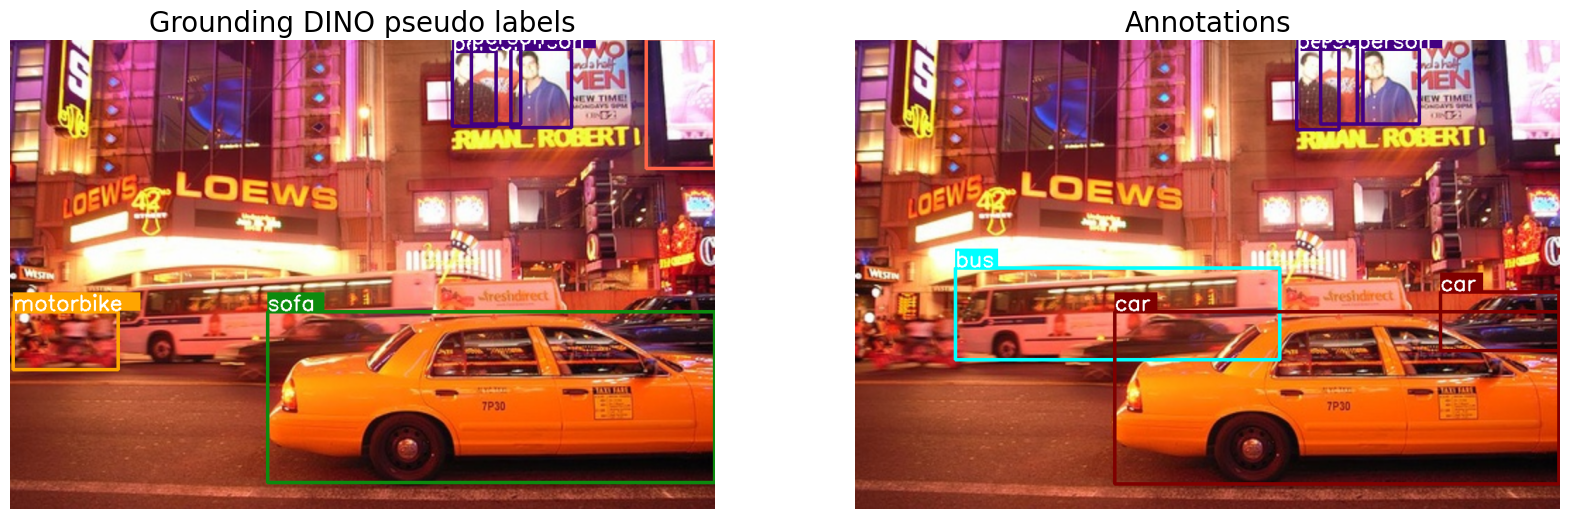

In [265]:
dataset_dir = '../datasets/VOC'
split = 'test'
files = sorted([x.split('.')[0] for x in os.listdir(f'{dataset_dir}/images/{split}')])
os.makedirs('images/gd_vs_orig', exist_ok=True)

###########################
index = files[9]
image_file = f'{dataset_dir}/images/{split}/{index}.jpg'
label_file_orig = f'{dataset_dir}/labels/{split}_orig/{index}.txt'
label_file_GD = f'{dataset_dir}/labels/{split}_GD/{index}.txt'


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ann = draw_annotations(image_file, label_file_orig)
pred = draw_annotations(image_file, label_file_GD)
print('predictions - ', pred[1])
print('annotations - ', ann[1])

axs[0].axis('off')


axs[0].imshow(pred[0])
axs[0].set_title('Grounding DINO pseudo labels',fontsize=20)


axs[1].axis('off')
axs[1].set_title('Annotations',fontsize=20)
axs[1].imshow(ann[0])

# draw_annotations(image_file, label_file_orig)
# plt.show()

# filename = 
fig.savefig(f'images/gd_vs_orig/{index}.png')



In [19]:
def draw_legend_existing(class_names, image = None, existing_labels = None):
    if image is None:
        background = np.ones((375*2, 150*2, 3), dtype=np.uint8)*255
    else:
        background = np.ones((image.shape[0] *2, 300, 3)) *255


    t_v_padding = 100
    t_h_padding = 30

    b_v_padding = 90
    b_h_padding = 10


    step = background.shape[0]//len(class_names)
    sq_size = 10


    if existing_labels is not None:
        label_indexes = [class_names.index(x) for x in existing_labels]
        class_names = existing_labels
    else:
        label_indexes = [x for x in range(len(class_names))]

    
    for index, (name, label_index) in enumerate(zip(class_names, label_indexes)):
        y = step * index
        # Отобразить прямоугольник на изображении

        y_min = y - sq_size//2 + b_v_padding
        y_max = y + sq_size//2 + b_v_padding

        image = cv2.rectangle(background, (b_h_padding, y_min), (b_h_padding + sq_size, y_max), color=colors[label_index], thickness=cv2.FILLED)
        
        # Добавить метку класса
        image = cv2.putText(image, class_names[index], (t_h_padding, y + t_v_padding), 
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=[0,0,0], thickness=1)
    return image


image 1/1 /home/nikolay/Documents/Projects/Diploma/notebooks/datasets/VOC_pseudo_labels/images/test/000006.jpg: 480x640 1 chair, 1 diningtable, 1 pottedplant, 92.1ms
Speed: 8.1ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/nikolay/Documents/Projects/Diploma/notebooks/datasets/VOC_pseudo_labels/images/test/000006.jpg: 480x640 1 chair, 1 diningtable, 1 pottedplant, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/nikolay/Documents/Projects/Diploma/notebooks/datasets/VOC_pseudo_labels/images/test/000006.jpg: 480x640 5 chairs, 1 diningtable, 1 pottedplant, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


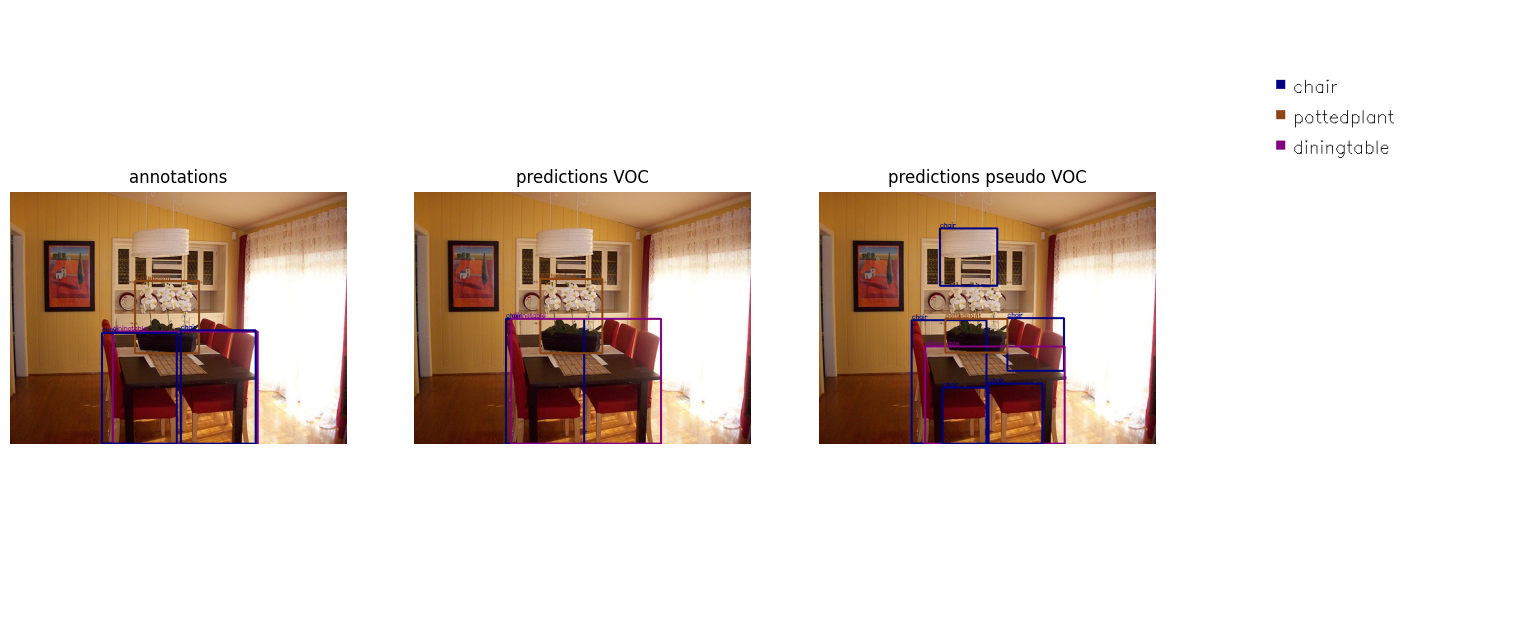

In [22]:
index = '000006'
image_file = f'datasets/VOC_pseudo_labels/images/test/{index}.jpg'
label_file = f'datasets/VOC_pseudo_labels/labels/test/{index}.txt'
results = model_voc(source=image_file, device=0)
plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
annotated_img, annotated_labels = draw_annotations(image_file, label_file)
plt.axis('off')
plt.imshow(annotated_img)
plt.title('annotations')

plt.subplot(1,4,2)
results_voc = model_voc(source=image_file, device=0)
predict_img, predict_labels = draw_boxes(results_voc[0])
plt.axis('off')
plt.imshow(predict_img)
plt.title('predictions VOC')

plt.subplot(1,4,3)
results_pseudo_voc = model_pseudo_voc(source=image_file, device=0)
predict_img, predict_labels = draw_boxes(results_pseudo_voc[0])
plt.axis('off')
plt.imshow(predict_img)
plt.title('predictions pseudo VOC')

existing_labels = list(set(annotated_labels) | set(predict_labels))

plt.subplot(1,4,4)
plt.imshow(draw_legend_existing(class_names, image = None, existing_labels=existing_labels))
plt.axis('off')


plt.show()



Text(0.5, 1.0, 'annotations')

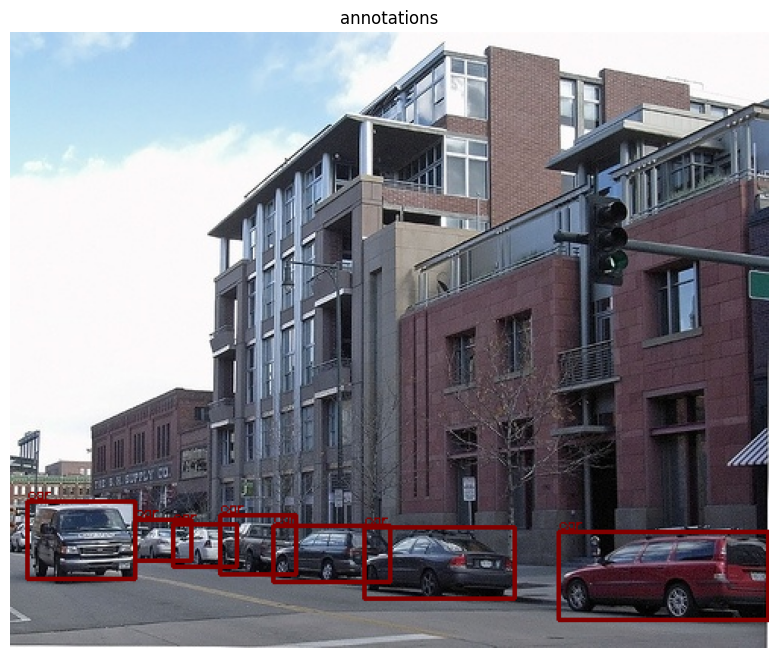

In [14]:
plt.figure(figsize=(20,8))
annotated_img, annotated_labels = draw_annotations(image_file, label_file)
plt.axis('off')
plt.imshow(annotated_img)
plt.title('annotations')


image 1/1 /home/nikolay/Documents/Projects/Diploma/notebooks/datasets/VOC_pseudo_labels/images/test/000004.jpg: 544x640 8 cars, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Text(0.5, 1.0, 'predictions VOC')

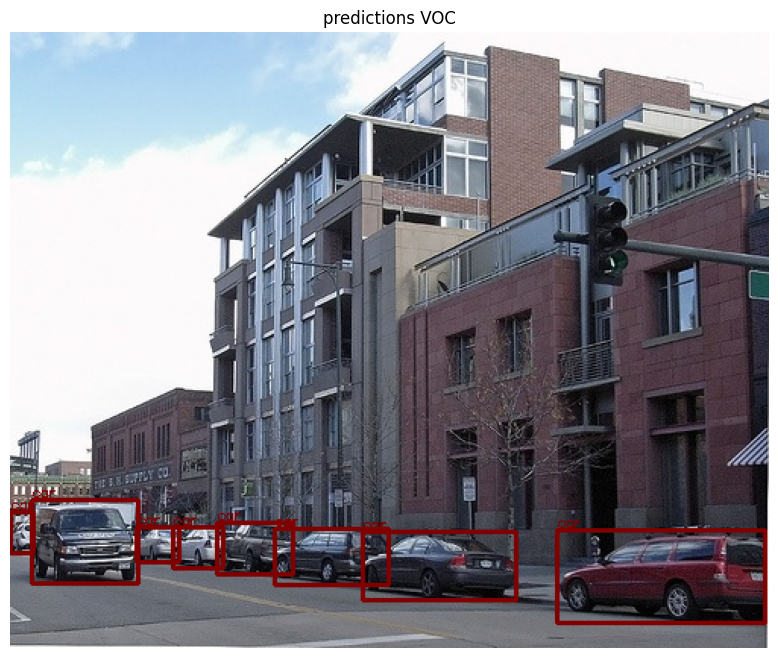

In [12]:
plt.figure(figsize=(20,8))
results_voc = model_voc(source=image_file, device=0)
predict_img, predict_labels = draw_boxes(results_voc[0])
plt.axis('off')
plt.imshow(predict_img)
plt.title('predictions VOC')

In [5]:
!ls ../runs/detect/orig_yolov8n_train_8batchsize

args.yaml			 R_curve.png	       train_batch59472.jpg
confusion_matrix_normalized.png  results.csv	       val_batch0_labels.jpg
confusion_matrix.png		 results.png	       val_batch0_pred.jpg
F1_curve.png			 train_batch0.jpg      val_batch1_labels.jpg
labels_correlogram.jpg		 train_batch1.jpg      val_batch1_pred.jpg
labels.jpg			 train_batch2.jpg      val_batch2_labels.jpg
P_curve.png			 train_batch59470.jpg  val_batch2_pred.jpg
PR_curve.png			 train_batch59471.jpg  weights


In [2]:
train_path_GD = [
    '../runs/detect/train_val_GD_yolov8n_train/results.csv',
    '../runs/detect/train_val_GD_yolov8s_train/results.csv',
    '../runs/detect/train_val_GD_yolov8m_train/results.csv',
    '../runs/detect/train_val_GD_yolov8l_train/results.csv',
    '../runs/detect/train_val_GD_yolov8x_train/results.csv',
    ]

test_path_GD = [
    '../runs/detect/train_val_GD_yolov8n_test/results.pickle',
    '../runs/detect/train_val_GD_yolov8s_test/results.pickle',
    '../runs/detect/train_val_GD_yolov8m_test/results.pickle',
    '../runs/detect/train_val_GD_yolov8l_test/results.pickle',
    '../runs/detect/train_val_GD_yolov8x_test/results.pickle',
    ]

model_names = ['nano_32', 'small', 'medium', 'large', 'extra-large',]

def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df

dfs_train_GD = [prepare_df(x) for x in train_path_GD]
data_test_GD = [pickle.load(open(x, "rb")) for x in test_path_GD]

In [3]:
train_path = [
    '../runs/detect/orig_yolov8n_train/results.csv',
    '../runs/detect/orig_yolov8s_train/results.csv',
    '../runs/detect/orig_yolov8m_train/results.csv',
    '../runs/detect/orig_yolov8l_train/results.csv',
    '../runs/detect/orig_yolov8x_train/results.csv',
    # '../runs/detect/orig_yolov8n_train_8batchsize/results.csv',
    ]

test_path = [
    '../runs/detect/orig_yolov8n_test/results.pickle',
    '../runs/detect/orig_yolov8s_test/results.pickle',
    '../runs/detect/orig_yolov8m_test/results.pickle',
    '../runs/detect/orig_yolov8l_test/results.pickle',
    '../runs/detect/orig_yolov8x_test/results.pickle',
    # '../runs/detect/orig_yolov8n_test_8batchsize/results.pickle',

    ]

model_names = ['nano_32', 'small', 'medium', 'large', 'extra-large']

def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df

dfs_train = [prepare_df(x) for x in train_path]
data_test = [pickle.load(open(x, "rb")) for x in test_path]

In [7]:
data_test[2].map

0.5574826250251895

In [22]:
data_test[2].ap50.mean()

0.7523165531407381

In [33]:
# ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
#        'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
#        'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
#        'lr/pg0', 'lr/pg1', 'lr/pg2']

In [95]:
[f'{x} ({y})' for x, y in list(zip(model_names, parametrs))]

['<generator object <genexpr> at 0x7f4b6ce62960> (3)']

In [114]:
(np.array(map5095_orig) - np.array(map5095_GD))/np.array(map50_orig)

array([   0.092122,    0.015385,    0.060326,    0.070935,    0.069172])

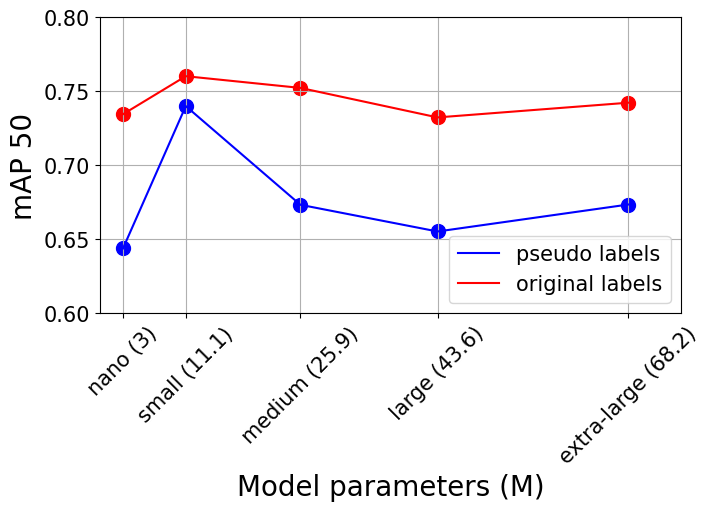

In [4]:
import matplotlib.pyplot as plt

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

map5095_GD = [x.map for x in data_test_GD]
map50_GD = [x.map50 for x in data_test_GD]
map5095_orig = [x.map for x in data_test]
map50_orig = [x.map50 for x in data_test]


parametrs = [3, 11.1, 25.9, 43.6, 68.2]
model_names = [f'{x} ({y})' for x, y in list(zip(model_names, parametrs))]


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 5),
                        sharex=True, sharey=True, layout="constrained")
markers = ['o', 'o', 'o', 'o', 'o']

for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map50_GD[i], s=100, marker=markers[i], color='blue')
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map50_orig[i], s=100, marker=markers[i], color='red')



axs.plot(parametrs, map50_GD, color='blue', linewidth=1.5, label='pseudo labels')
axs.plot(parametrs, map50_orig, color='red', linewidth=1.5, label='original labels')


axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.6, 0.8)
axs.grid(True)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Model parameters (M)", fontsize=20)
axs.set_ylabel("mAP 50", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

# Указание названий каждой модели вместо оси X
plt.xticks(parametrs, model_names, rotation=45, fontsize=15)

plt.show()

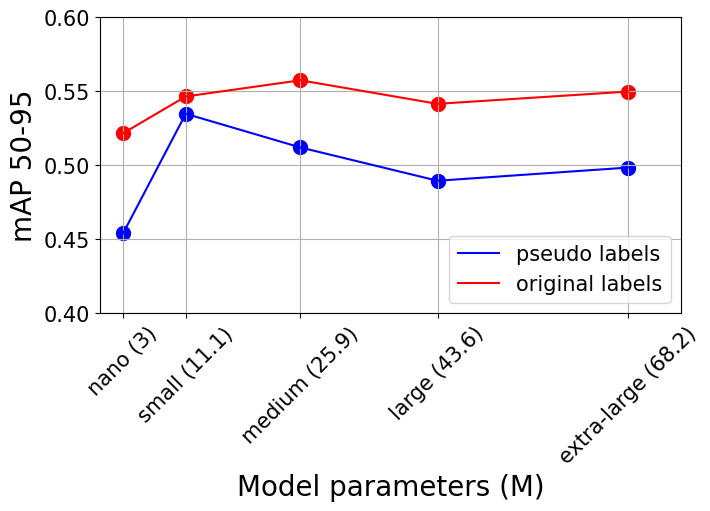

In [108]:
import matplotlib.pyplot as plt

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

map5095_GD = [x.map for x in data_test_GD]
map50_GD = [x.map50 for x in data_test_GD]
map5095_orig = [x.map for x in data_test]
map50_orig = [x.map50 for x in data_test]


parametrs = [3, 11.1, 25.9, 43.6, 68.2]
model_names = [f'{x} ({y})' for x, y in list(zip(model_names, parametrs))]


# colors_models = [
#     '#00ff00',
#     '#00aacc',
#     '#0000ff',
#     '#ffa900',
#     '#ff0000',
# ]
# colors_models = ['#000000']*5

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 5),
                        sharex=True, sharey=True, layout="constrained")
# markers = ['o', 's', '^', 'x', 'D']
markers = ['o', 'o', 'o', 'o', 'o']

for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map5095_GD[i], s=100, marker=markers[i], color='blue')
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map5095_orig[i], s=100, marker=markers[i], color='red')



axs.plot(parametrs, map5095_GD, color='blue', linewidth=1.5, label='pseudo labels')
axs.plot(parametrs, map5095_orig, color='red', linewidth=1.5, label='original labels')


axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.4, 0.6)
axs.grid(True)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Model parameters (M)", fontsize=20)
axs.set_ylabel("mAP 50-95", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

# Указание названий каждой модели вместо оси X
plt.xticks(parametrs, model_names, rotation=45, fontsize=15)

plt.show()


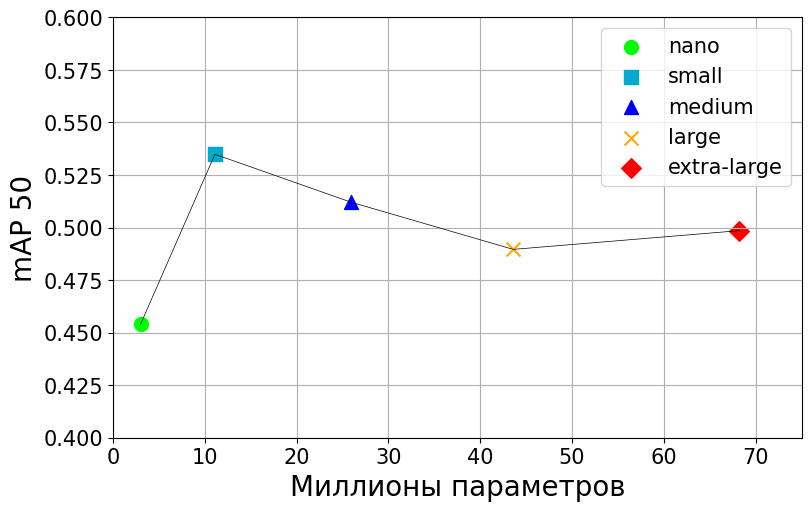

In [68]:
import matplotlib.pyplot as plt

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']
map5095 = [x.map for x in data_test_GD]
map50 = [x.map50 for x in data_test_GD]
parametrs = [3, 11.1, 25.9, 43.6, 68.2]

metric = map5095

colors_models = [
    '#00ff00',
    '#00aacc',
    '#0000ff',
    '#ffa900',
    '#ff0000',
]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5),
                        sharex=True, sharey=True, layout="constrained")
markers = ['o', 's', '^', 'x', 'D']
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], metric[i], s=100, marker=markers[i], color=colors_models[i], label=model_names[i])
axs.plot(parametrs, metric, color='black', linewidth=0.5)
axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.4, 0.6)
axs.grid(True)
axs.legend(fontsize=15)

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Миллионы параметров", fontsize=20)
axs.set_ylabel("mAP 50", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

plt.show()



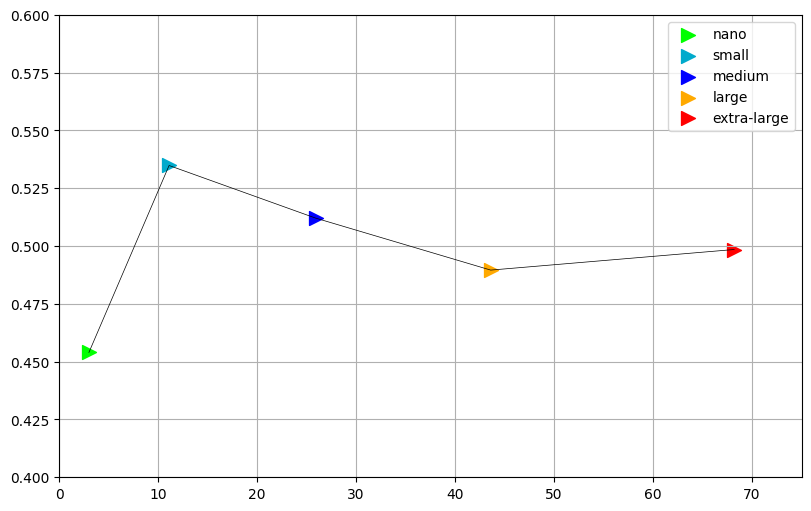

In [58]:
import matplotlib.pyplot as plt

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']
map5095 = [x.map for x in data_test_GD]
map50 = [x.map50 for x in data_test_GD]
# parametrs = [3_009_548, 11_166_560, 25_902_640, 43_691_520, 68_229_648]
parametrs = [3, 11.1, 25.9, 43.6, 68.2]

metric = map5095

colors_models = [
    '#00ff00',
    '#00aacc',
    '#0000ff',
    '#ffa900',
    '#ff0000',
]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5),
                        sharex=True, sharey=True, layout="constrained")
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], metric[i], s=100, marker=">", color=colors_models[i], label=model_names[i])
axs.plot(parametrs, metric, color='black', linewidth=0.5)
axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.4, 0.6)
axs.grid(True)
axs.legend()

plt.show()


In [5]:
print('GD map50-95 , nano_32', data_test_GD[0].map)
print('GD map50-95 , small', data_test_GD[1].map)
print('GD map50-95 , medium', data_test_GD[2].map)
print('GD map50-95 , large', data_test_GD[3].map)
print('GD map50-95 , xlarge', data_test_GD[4].map)
print()
print('map50-95 , nano_32', data_test[0].map)
print('map50-95 , small', data_test[1].map)
print('map50-95 , medium', data_test[2].map)
print('map50-95 , large', data_test[3].map)
print('map50-95 , xlarge', data_test[4].map)

GD map50-95 , nano_32 0.4539858244851001
GD map50-95 , small 0.5348441503069838
GD map50-95 , medium 0.5120983846872005
GD map50-95 , large 0.48960355580266735
GD map50-95 , xlarge 0.4985047324017917

map50-95 , nano_32 0.5216552126964943
map50-95 , small 0.5465407400186441
map50-95 , medium 0.5574826250251895
map50-95 , large 0.5415554404437499
map50-95 , xlarge 0.5498521576738389


In [7]:
print('map , nano 32',dfs_train[0]['metrics/mAP50(B)'].max())
print('map , small',dfs_train[1]['metrics/mAP50(B)'].max())
print('map , medium',dfs_train[2]['metrics/mAP50(B)'].max())
print('map , large',dfs_train[3]['metrics/mAP50(B)'].max())
print('map , extra large',dfs_train[4]['metrics/mAP50(B)'].max())
print('map , nano 8',dfs_train[5]['metrics/mAP50(B)'].max())

map , nano 32 0.73658
map , small 0.76007
map , medium 0.75306
map , large 0.74588
map , extra large 0.73968
map , nano 8 0.73543


In [6]:
def plot_metrics(dataframes, metric_name, indexes, axis, names):
    if indexes is None:
        indexes = range(len(dataframes))
    if axis is None:
        fig, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 5))
        
    for index in indexes:
        metric = dataframes[index][metric_name]
        axis.plot(metric, label = names[index])
        axis.grid(which = "major", linewidth = 1)
        axis.xaxis.set_tick_params(labelsize=18)
        axis.yaxis.set_tick_params(labelsize=18)
        axis.set_title(metric_name, fontsize = 30)
        axis.set_xlabel('Epoch', fontsize = 24,)
        axis.set_ylabel('Loss', fontsize = 24)
        axis.legend(fontsize = 18)
        

In [52]:
print('map , small',dfs_train_GD[1]['metrics/mAP50(B)'].max())

map , small 0.67316


In [ ]:
'train/box_loss', 'train/cls_loss', 'train/dfl_loss'

In [9]:
dfs_train_GD[1].columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

In [15]:
dfs_train_GD[0]['val/dfl_loss']

0      1.1104
1      1.2138
2      1.2712
3      1.2696
4      1.2915
        ...  
195    1.2541
196    1.2534
197    1.2517
198    1.2514
199    1.2492
Name: val/dfl_loss, Length: 200, dtype: float64

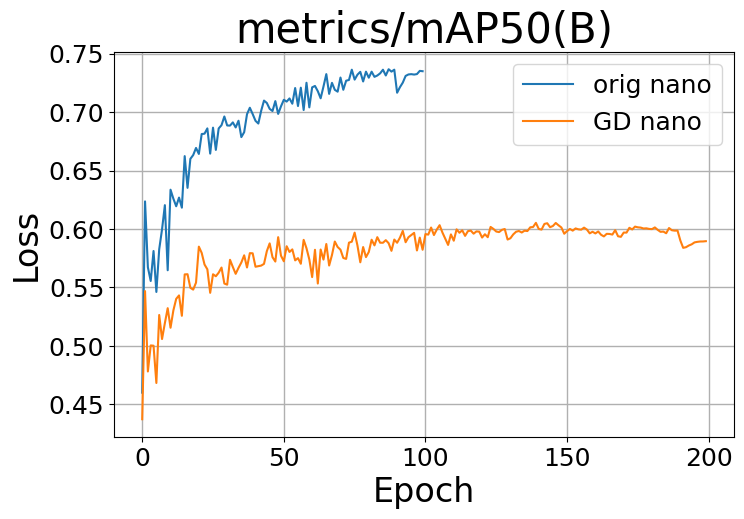

In [12]:
plot_metrics(dataframes = [dfs_train[0], dfs_train_GD[0]], 
             metric_name = 'metrics/mAP50(B)', 
             indexes = None, 
             axis = None, 
             names = ['orig nano', 'GD nano'])

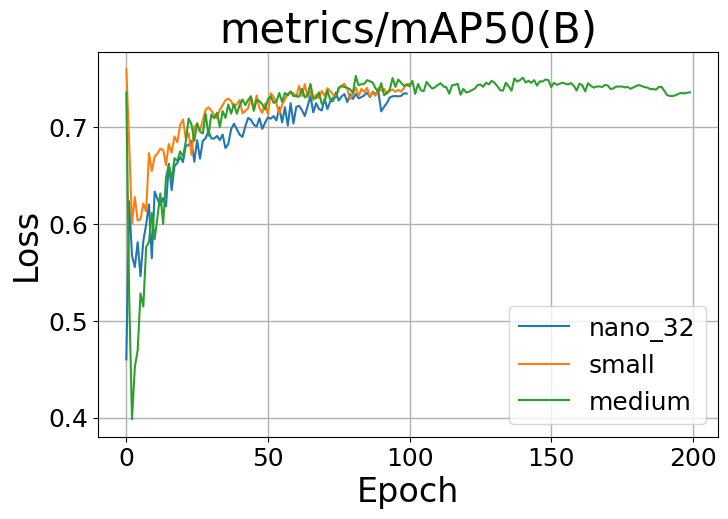

In [28]:
plot_metrics(dataframes = dfs_train, 
             metric_name = 'metrics/mAP50(B)', 
             indexes = [0,1,2], 
             axis = None, 
             names = model_names)

In [25]:
dfs_train[[1,2]]

TypeError: list indices must be integers or slices, not list

In [10]:
df = pd.read_csv('../runs/detect/orig_yolov8s_train/results.csv')
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,0.93759,2.18230,1.21660,0.71274,0.71001,0.76007,0.54960,0.91061,1.1845,1.1394,0.000138,0.000138,0.000138
1,2,0.94078,1.29590,1.21660,0.67144,0.63655,0.68328,0.47239,1.02190,1.2610,1.2570,0.000275,0.000275,0.000275
2,3,1.04540,1.35950,1.29210,0.61905,0.57092,0.60064,0.38991,1.14870,1.3499,1.3598,0.000410,0.000410,0.000410
3,4,1.05780,1.38270,1.30430,0.64482,0.57683,0.62789,0.40547,1.16040,1.3264,1.3534,0.000409,0.000409,0.000409
4,5,1.06060,1.32100,1.30000,0.60686,0.57369,0.60353,0.38940,1.18720,1.3160,1.4047,0.000409,0.000409,0.000409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,0.54309,0.43406,0.97937,0.77944,0.65487,0.73885,0.53284,1.08570,1.0286,1.3573,0.000156,0.000156,0.000156
97,98,0.54806,0.44736,0.98692,0.75800,0.67046,0.73690,0.52712,1.08710,1.0284,1.3679,0.000153,0.000153,0.000153
98,99,0.54577,0.43589,0.98066,0.76740,0.65804,0.74058,0.53403,1.08650,1.0319,1.3642,0.000150,0.000150,0.000150
99,100,0.54873,0.43812,0.98541,0.76773,0.66897,0.74485,0.53817,1.09020,1.0333,1.3628,0.000147,0.000147,0.000147


In [16]:
df.columns

df[df.columns[0]].values

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [42]:
# df['train/box_loss']
# df.columns[0].split(' ')[-1]
df.columns = [x.split(' ')[-1] for x in df.columns]

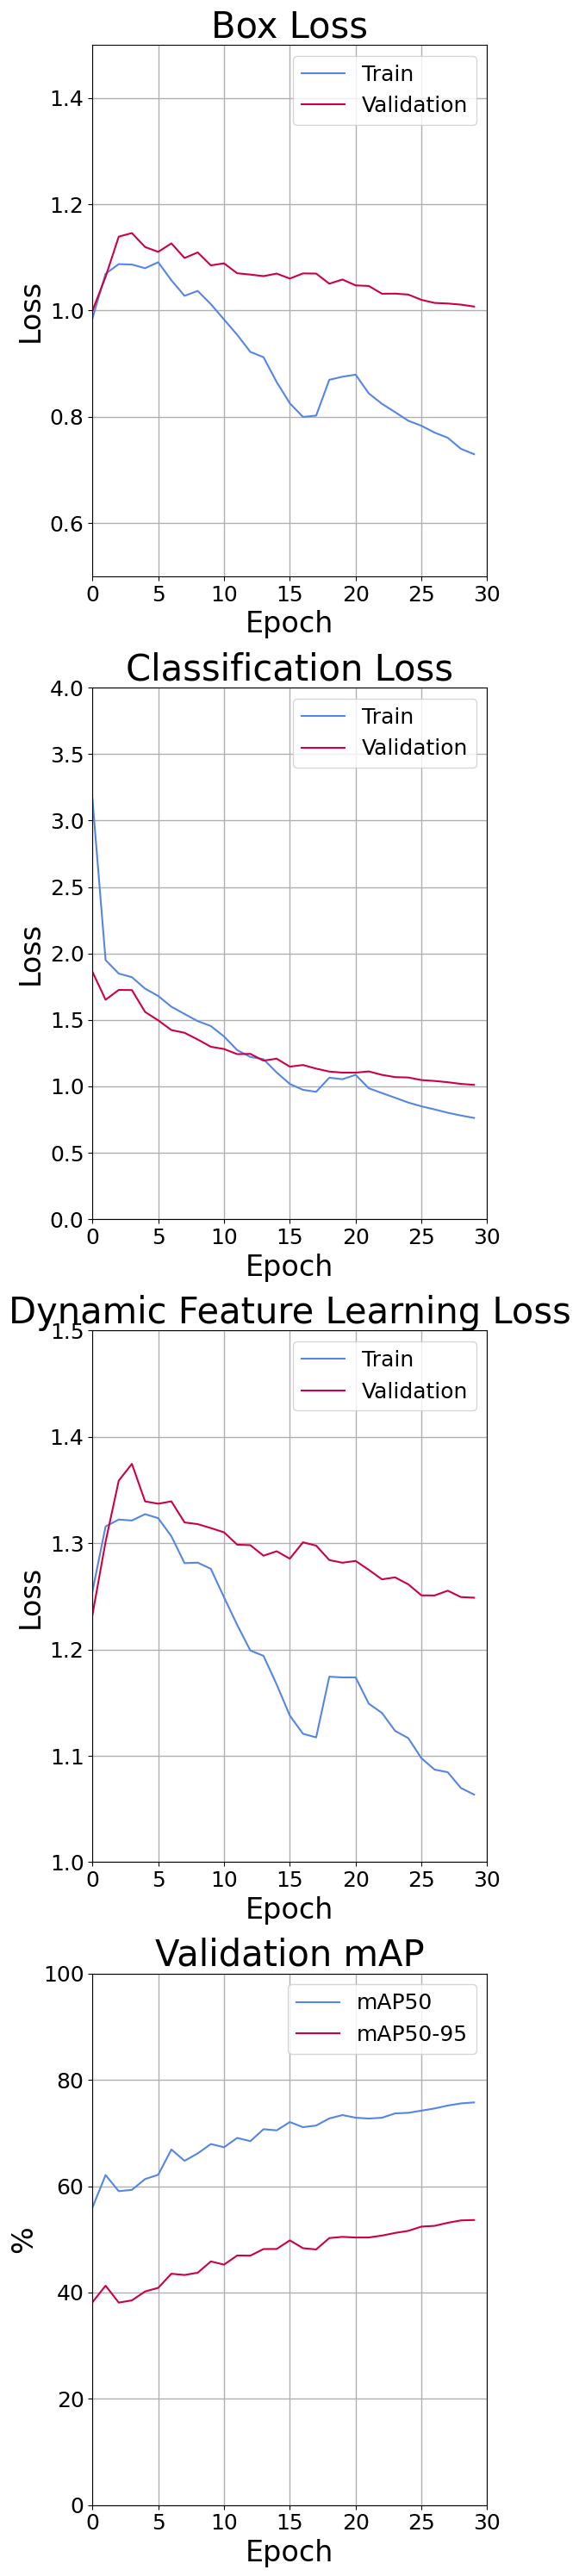

In [27]:
# Load the Results Excel file into a Pandas DataFrame
# df = pd.read_excel('Data/Training Results/Results.xlsx')
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = [x.split(' ')[-1] for x in df.columns]

# Extract the relevant columns
train_box_loss = df['train/box_loss']
val_box_loss = df['val/box_loss']
train_cls_loss = df['train/cls_loss']
val_cls_loss = df['val/cls_loss']
train_dfl_loss = df['train/dfl_loss']
val_dfl_loss = df['val/dfl_loss']
val_mAP50 = df['metrics/mAP50(B)'] * 100
val_mAP50_95 = df['metrics/mAP50-95(B)'] * 100

# Create the subplots
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (6, 30))

# Plotting the box loss
axes[0].plot(train_box_loss, label = 'Train', color = "#5585E6")
axes[0].plot(val_box_loss, label = 'Validation', color = "#CD0046")
axes[0].grid(which = "major", linewidth = 1)
axes[0].set_xlim(0, 30)
axes[0].set_ylim(0.5, 1.5)
axes[0].xaxis.set_tick_params(labelsize=18)
axes[0].yaxis.set_tick_params(labelsize=18)
axes[0].set_title('Box Loss', fontsize = 30)
axes[0].set_xlabel('Epoch', fontsize = 24,)
axes[0].set_ylabel('Loss', fontsize = 24)
axes[0].legend(fontsize = 18)

# Plotting the classification loss
axes[1].plot(train_cls_loss, label = 'Train', color = "#5585E6")
axes[1].plot(val_cls_loss, label = 'Validation', color = "#CD0046")
axes[1].grid(which = "major", linewidth = 1)
axes[1].set_xlim(0, 30)
axes[1].set_ylim(0, 4)
axes[1].xaxis.set_tick_params(labelsize=18)
axes[1].yaxis.set_tick_params(labelsize=18)
axes[1].set_title('Classification Loss', fontsize = 30)
axes[1].set_xlabel('Epoch', fontsize = 24,)
axes[1].set_ylabel('Loss', fontsize = 24)
axes[1].legend(fontsize = 18)

# Plotting the DFL loss
axes[2].plot(train_dfl_loss, label = 'Train', color = "#5585E6")
axes[2].plot(val_dfl_loss, label = 'Validation', color = "#CD0046")
axes[2].grid(which = "major", linewidth = 1)
axes[2].set_xlim(0, 30)
axes[2].set_ylim(1, 1.5)

axes[2].xaxis.set_tick_params(labelsize=18)
axes[2].yaxis.set_tick_params(labelsize=18)
axes[2].set_title('Dynamic Feature Learning Loss', fontsize = 30)
axes[2].set_xlabel('Epoch', fontsize = 24,)
axes[2].set_ylabel('Loss', fontsize = 24)
axes[2].legend(fontsize = 18)

# Plotting mAP50 and mAP50-95
axes[3].plot(val_mAP50, label = 'mAP50', color = "#5585E6")
axes[3].plot(val_mAP50_95, label='mAP50-95', color = "#CD0046")
axes[3].grid(which = "major", linewidth = 1)
axes[3].set_xlim(0, 30)
axes[3].set_ylim(0, 100)

axes[3].xaxis.set_tick_params(labelsize=18)
axes[3].yaxis.set_tick_params(labelsize=18)
axes[3].set_title('Validation mAP', fontsize = 30)
axes[3].set_xlabel('Epoch', fontsize = 24,)
axes[3].set_ylabel('%', fontsize = 24)


axes[3].legend(fontsize = 18)

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the plots
plt.show()

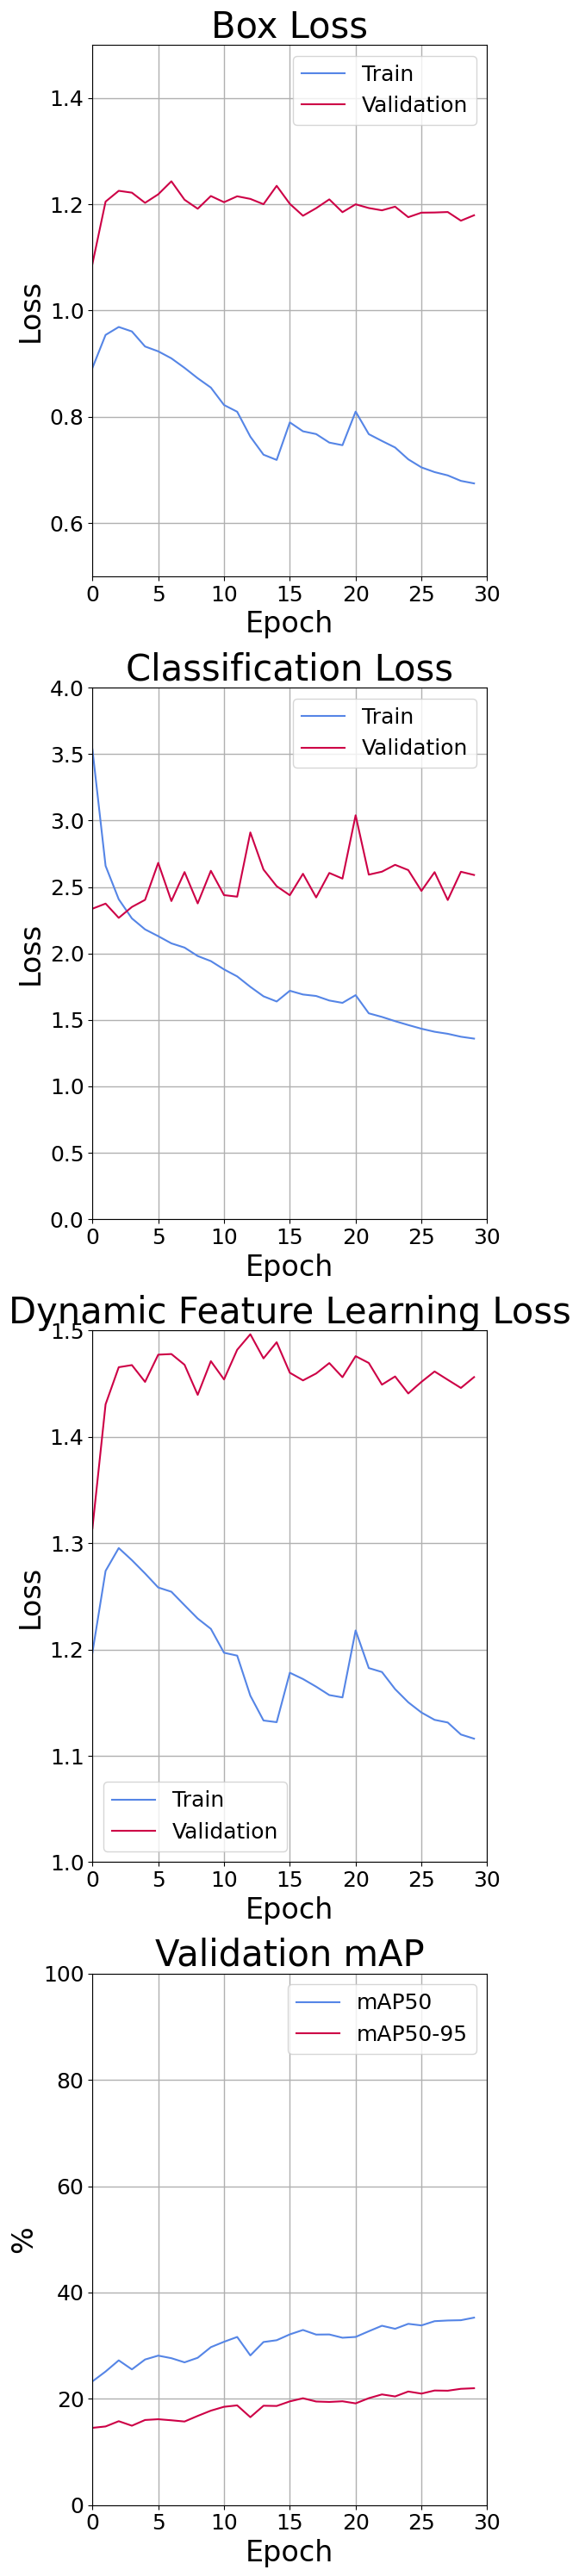

In [25]:
# Load the Results Excel file into a Pandas DataFrame
# df = pd.read_excel('Data/Training Results/Results.xlsx')
df = pd.read_csv('runs/detect/train2/results.csv')
df.columns = [x.split(' ')[-1] for x in df.columns]

# Extract the relevant columns
train_box_loss = df['train/box_loss']
val_box_loss = df['val/box_loss']
train_cls_loss = df['train/cls_loss']
val_cls_loss = df['val/cls_loss']
train_dfl_loss = df['train/dfl_loss']
val_dfl_loss = df['val/dfl_loss']
val_mAP50 = df['metrics/mAP50(B)'] * 100
val_mAP50_95 = df['metrics/mAP50-95(B)'] * 100

# Create the subplots
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (6, 30))


# Plotting the box loss
axes[0].plot(train_box_loss, label = 'Train', color = "#5585E6")
axes[0].plot(val_box_loss, label = 'Validation', color = "#CD0046")
axes[0].grid(which = "major", linewidth = 1)
axes[0].set_xlim(0, 30)
axes[0].set_ylim(0.5, 1.5)
axes[0].xaxis.set_tick_params(labelsize=18)
axes[0].yaxis.set_tick_params(labelsize=18)
axes[0].set_title('Box Loss', fontsize = 30)
axes[0].set_xlabel('Epoch', fontsize = 24,)
axes[0].set_ylabel('Loss', fontsize = 24)
axes[0].legend(fontsize = 18)

# Plotting the classification loss
axes[1].plot(train_cls_loss, label = 'Train', color = "#5585E6")
axes[1].plot(val_cls_loss, label = 'Validation', color = "#CD0046")
axes[1].grid(which = "major", linewidth = 1)
axes[1].set_xlim(0, 30)
axes[1].set_ylim(0, 4)
axes[1].xaxis.set_tick_params(labelsize=18)
axes[1].yaxis.set_tick_params(labelsize=18)
axes[1].set_title('Classification Loss', fontsize = 30)
axes[1].set_xlabel('Epoch', fontsize = 24,)
axes[1].set_ylabel('Loss', fontsize = 24)
axes[1].legend(fontsize = 18)

# Plotting the DFL loss
axes[2].plot(train_dfl_loss, label = 'Train', color = "#5585E6")
axes[2].plot(val_dfl_loss, label = 'Validation', color = "#CD0046")
axes[2].grid(which = "major", linewidth = 1)
axes[2].set_xlim(0, 30)
axes[2].set_ylim(1, 1.5)

axes[2].xaxis.set_tick_params(labelsize=18)
axes[2].yaxis.set_tick_params(labelsize=18)
axes[2].set_title('Dynamic Feature Learning Loss', fontsize = 30)
axes[2].set_xlabel('Epoch', fontsize = 24,)
axes[2].set_ylabel('Loss', fontsize = 24)
axes[2].legend(fontsize = 18)

# Plotting mAP50 and mAP50-95
axes[3].plot(val_mAP50, label = 'mAP50', color = "#5585E6")
axes[3].plot(val_mAP50_95, label='mAP50-95', color = "#CD0046")
axes[3].grid(which = "major", linewidth = 1)
axes[3].set_xlim(0, 30)
axes[3].set_ylim(0, 100)

axes[3].xaxis.set_tick_params(labelsize=18)
axes[3].yaxis.set_tick_params(labelsize=18)
axes[3].set_title('Validation mAP', fontsize = 30)
axes[3].set_xlabel('Epoch', fontsize = 24,)
axes[3].set_ylabel('%', fontsize = 24)


axes[3].legend(fontsize = 18)

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the plots
plt.show()

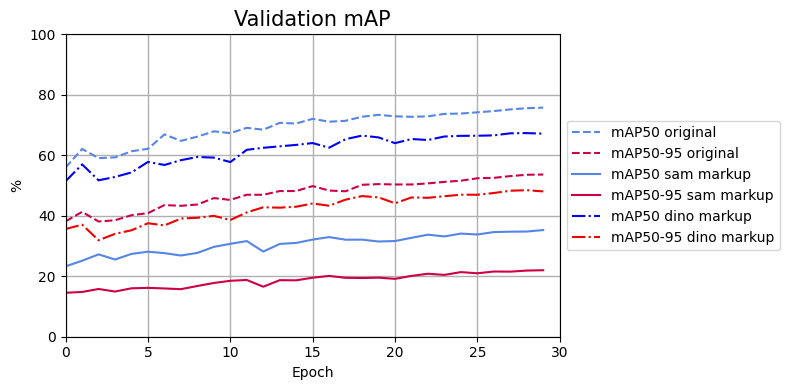

In [14]:
# Load the Results Excel file into a Pandas DataFrame
df = pd.read_csv('runs/detect/train_ORIG/results.csv')
df_sam = pd.read_csv('runs/detect/train_SAM/results.csv')
df_dino = pd.read_csv('runs/detect/train_DINO/results.csv')

df.columns = [x.split(' ')[-1] for x in df.columns]
df_sam.columns = [x.split(' ')[-1] for x in df.columns]
df_dino.columns = [x.split(' ')[-1] for x in df.columns]

# Extract the relevant columns
val_mAP50 = df['metrics/mAP50(B)'] * 100
val_mAP50_95 = df['metrics/mAP50-95(B)'] * 100
val_mAP50_sam = df_sam['metrics/mAP50(B)'] * 100
val_mAP50_95_sam = df_sam['metrics/mAP50-95(B)'] * 100
val_mAP50_dino = df_dino['metrics/mAP50(B)'] * 100
val_mAP50_95_dino = df_dino['metrics/mAP50-95(B)'] * 100

# Create the subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))


# Plotting mAP50 and mAP50-95
axes.plot(val_mAP50, label = 'mAP50 original', color = "#5585E6",  linestyle='--')
axes.plot(val_mAP50_95, label='mAP50-95 original', color = "#CD0046",  linestyle='--')
axes.plot(val_mAP50_sam, label = 'mAP50 sam markup', color = "#5585E6")
axes.plot(val_mAP50_95_sam, label='mAP50-95 sam markup', color = "#CD0046")
axes.plot(val_mAP50_dino, label = 'mAP50 dino markup', color = "#0000EE", linestyle='dashdot')
axes.plot(val_mAP50_95_dino, label='mAP50-95 dino markup', color = "#EE0000", linestyle='dashdot')
axes.grid(which = "major", linewidth = 1)
axes.set_xlim(0, 30)
axes.set_ylim(0, 100)
axes.set_title('Validation mAP', fontsize = 15)
axes.set_xlabel('Epoch')
axes.set_ylabel('%')
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the plots
plt.show()